# First Exploratory Data Analysis of Crypto Data

## Plotting
* Plot data
* Plot Correlations
* ACFs and PACFs
* Summary Statistics

## Goal: All things needed for a pre-causal analysis

In [17]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import ccf
import itertools
import glob
import os
import pyarrow.parquet as pq

# Set style for better visualizations
sns.set_theme()
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 6]

## Data Loading
First, let's load our data files containing the cryptocurrency data.


i# %% [markdown]
## Data Loading
Load the cryptocurrency data from parquet files.

In [18]:
def load_all_crypto_data(data_dir="../data/processed/"):
    all_data = {}
    for file in glob.glob(os.path.join(data_dir, "*.parquet")):
        symbol = os.path.basename(file).split('_')[0]  # Get symbol from filename
        print(f"Loading {file}...")
        df = pq.read_table(file).to_pandas()
        all_data[symbol] = df
    return all_data

# Load the data
crypto_data = load_all_crypto_data()

# Debug data loading
print("\nLoaded symbols:", list(crypto_data.keys()))
for symbol, df in crypto_data.items():
    print(f"\nShape of {symbol} data:", df.shape)
    print(f"Columns:", df.columns.tolist())
    print(f"Sample of {symbol} data:")
    print(df[['timestamp', 'close']].head())

Loading ../data/processed/SOLUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading ../data/processed/ADAUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading ../data/processed/BTCUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading ../data/processed/DOGEUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading ../data/processed/XRPUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading ../data/processed/BNBUSDT_1m_2024-01-01_2024-02-01.parquet...
Loading ../data/processed/ETHUSDT_1m_2024-01-01_2024-02-01.parquet...

Loaded symbols: ['SOLUSDT', 'ADAUSDT', 'BTCUSDT', 'DOGEUSDT', 'XRPUSDT', 'BNBUSDT', 'ETHUSDT']

Shape of SOLUSDT data: (44641, 13)
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore', 'symbol']
Sample of SOLUSDT data:
            timestamp   close
0 2024-01-01 00:00:00  101.72
1 2024-01-01 00:01:00  101.88
2 2024-01-01 00:02:00  102.13
3 2024-01-01 00:03:00  102.27
4 2024-01-0

In [15]:
#crypto_data.keys()
import os
print(os.getcwd())

/home/nfiroo/Dropbox/Nick/BrevanHowardClassNotes/crypto/crypto_causality/notebooks


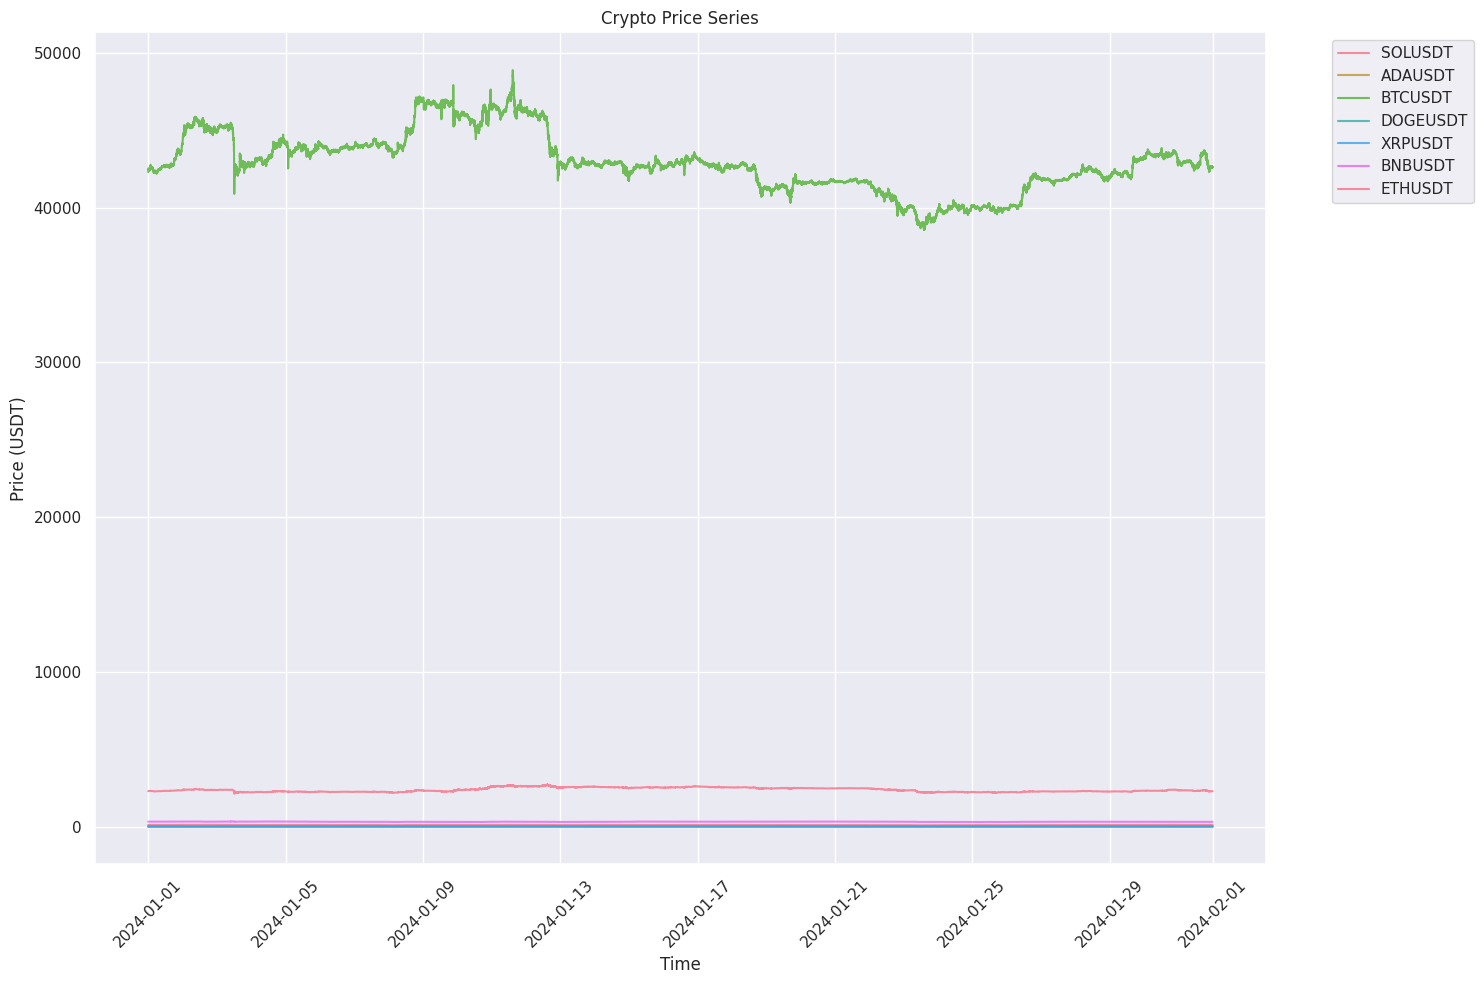

In [19]:
# Plot price series
plt.figure(figsize=(15, 10))

for symbol, df in crypto_data.items():
    plt.plot(
        df['timestamp'],
        df['close'],
        label=symbol,
        alpha=0.8
    )

plt.title('Crypto Price Series')
plt.xlabel('Time')
plt.ylabel('Price (USDT)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [20]:
# 2. Returns Calculation and Correlation Analysis
# Calculate returns for each crypto
returns_data = {}
for symbol, df in crypto_data.items():
    returns = pd.DataFrame()
    returns['timestamp'] = df['timestamp']
    returns['returns'] = df['close']
    returns_data[symbol] = returns

In [21]:
# Create a combined returns dataframe
combined_returns = pd.DataFrame()
for symbol, returns in returns_data.items():
    combined_returns[symbol] = returns['returns']
combined_returns.index = list(returns_data.values())[0]['timestamp']

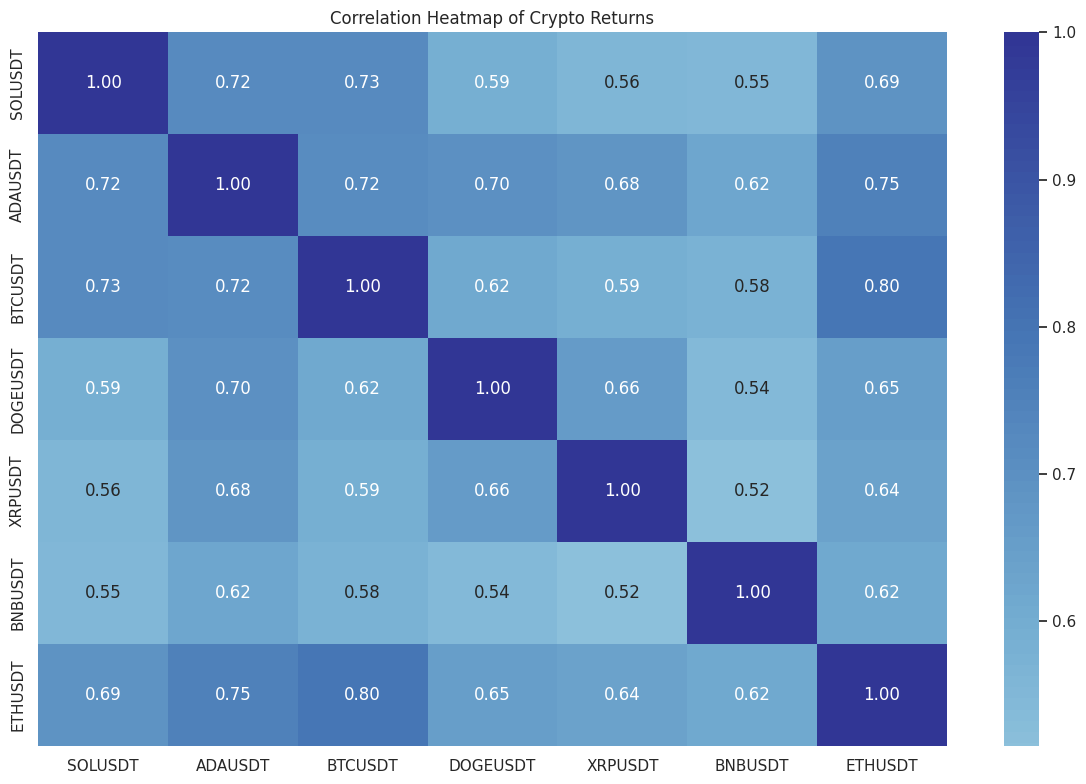

In [22]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    combined_returns.corr(),
    annot=True,
    cmap='RdYlBu',
    center=0,
    fmt='.2f'
)
plt.title('Correlation Heatmap of Crypto Returns')
plt.tight_layout()
plt.show()

## ACF and PACF Analysis
Analyze the autocorrelation and partial autocorrelation functions for each cryptocurrency.

In [23]:
def plot_acf_pacf(series, symbol, lags=50):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # ACF
    acf_values = acf(series.dropna(), nlags=lags)
    ax1.stem(range(len(acf_values)), acf_values)
    ax1.axhline(y=0, linestyle='-', color='black')
    ax1.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax1.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax1.set_title(f'Autocorrelation Function for {symbol}')

    # PACF
    pacf_values = pacf(series.dropna(), nlags=lags)
    ax2.stem(range(len(pacf_values)), pacf_values)
    ax2.axhline(y=0, linestyle='-', color='black')
    ax2.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax2.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    ax2.set_title(f'Partial Autocorrelation Function for {symbol}')

    plt.tight_layout()
    plt.show()


Analyzing SOLUSDT


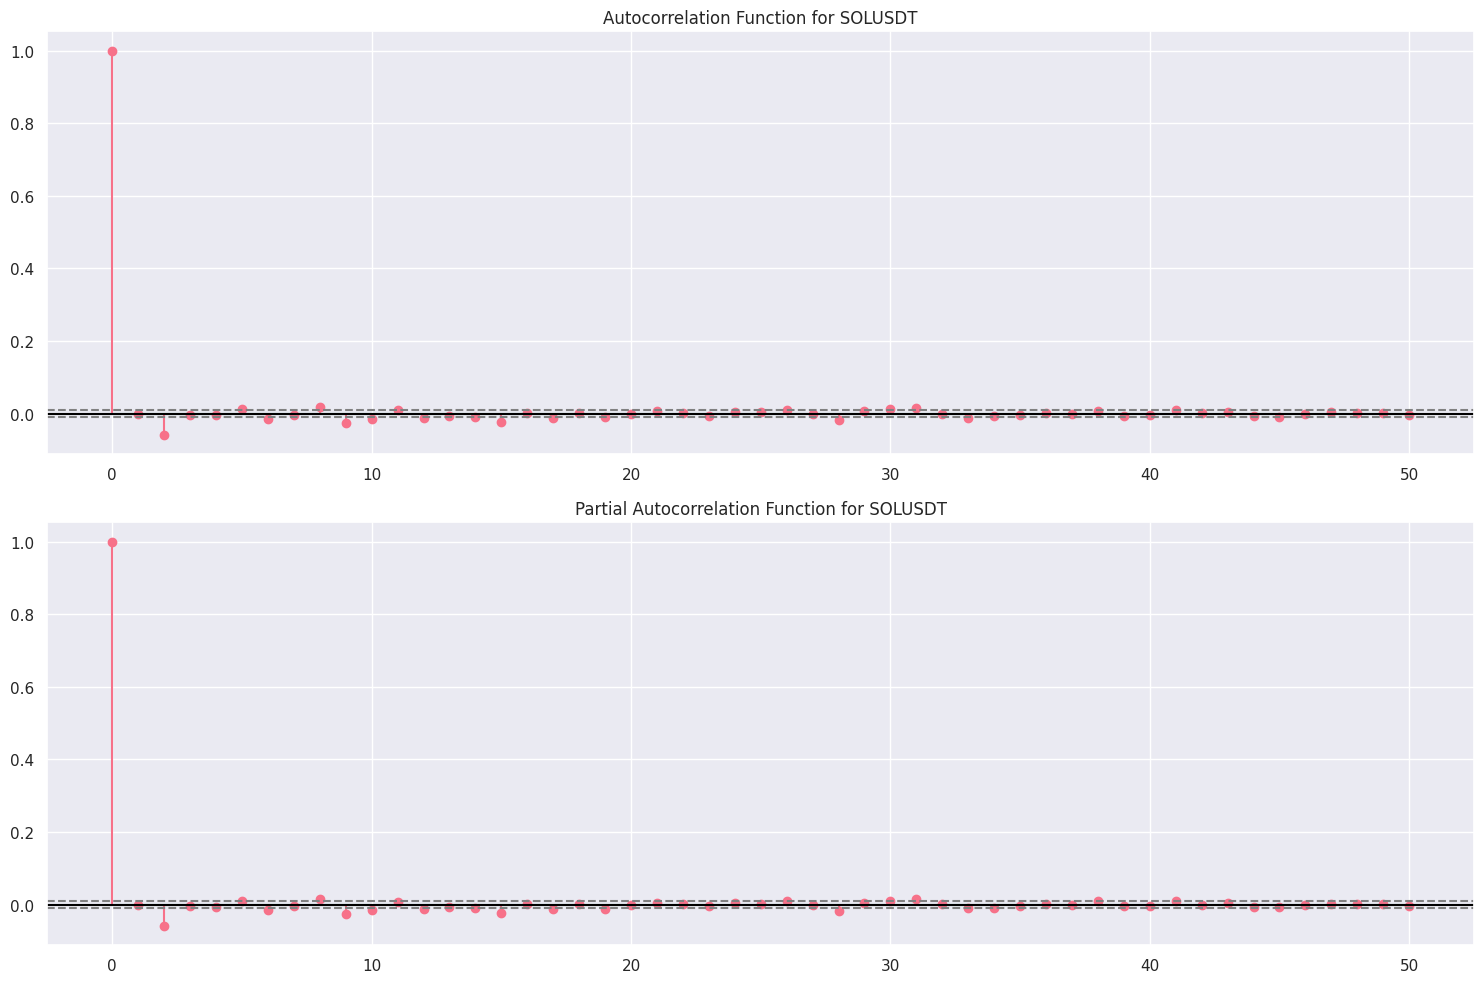


Analyzing ADAUSDT


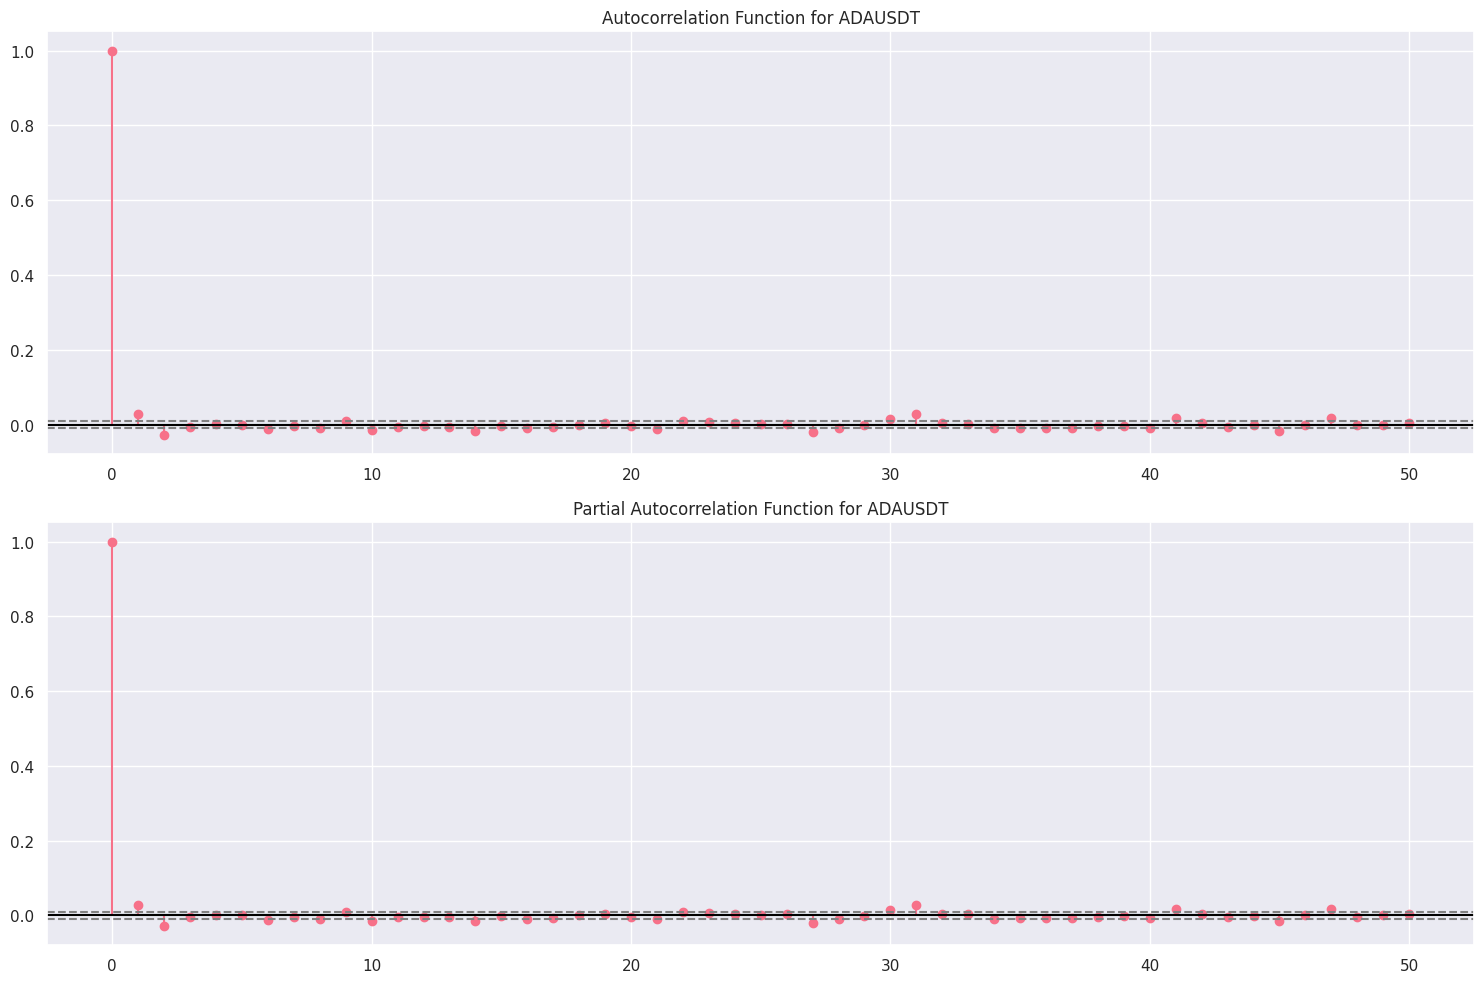


Analyzing BTCUSDT


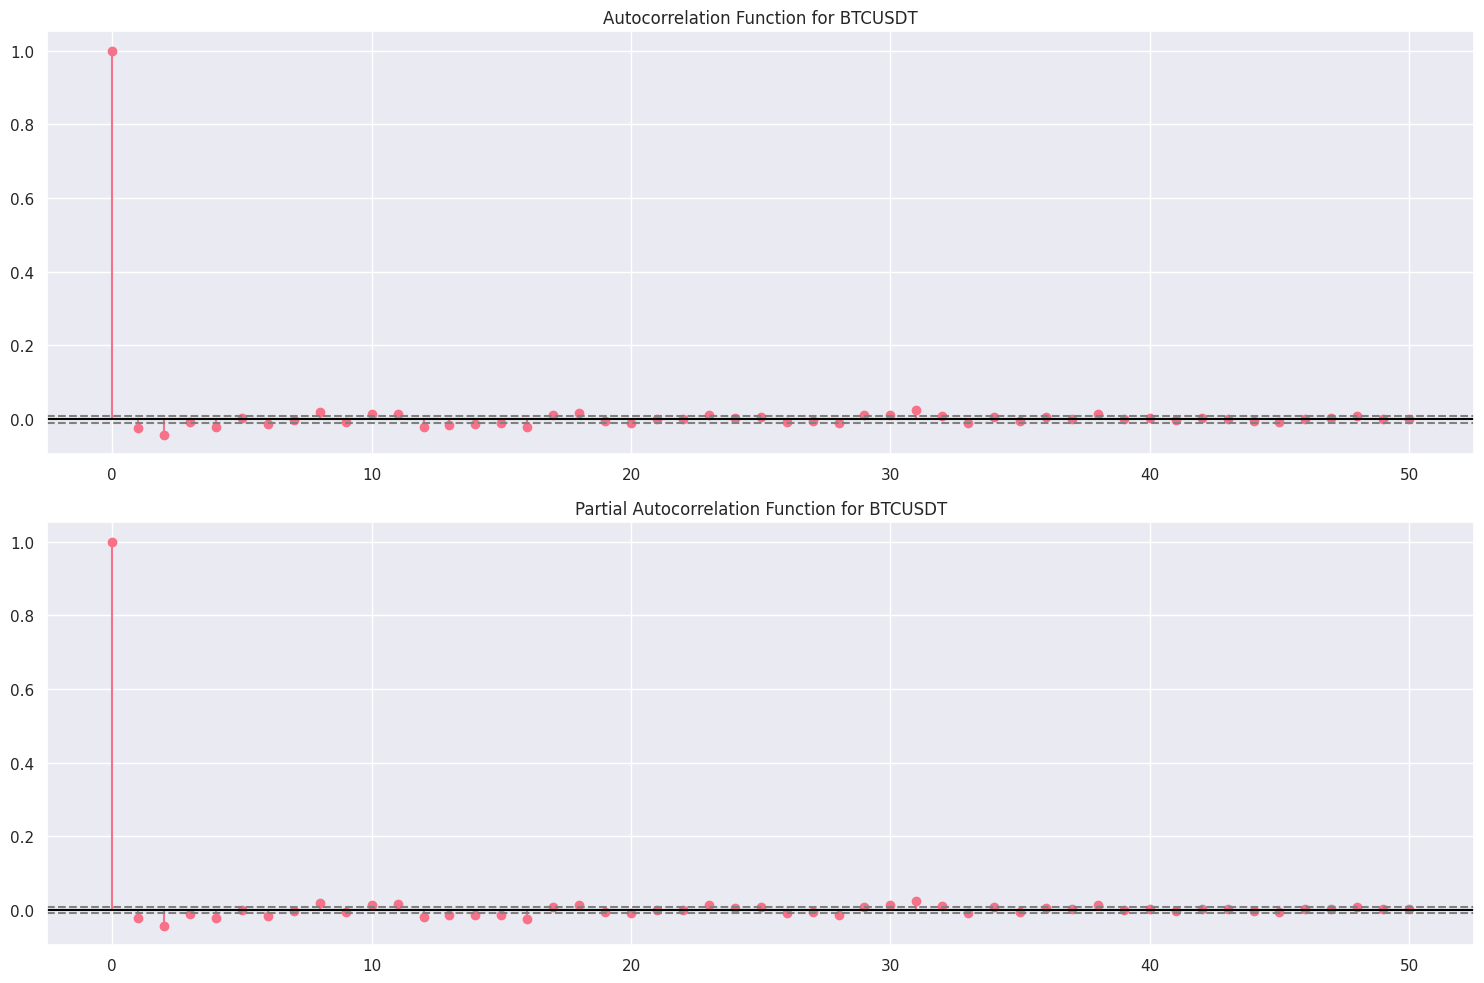


Analyzing DOGEUSDT


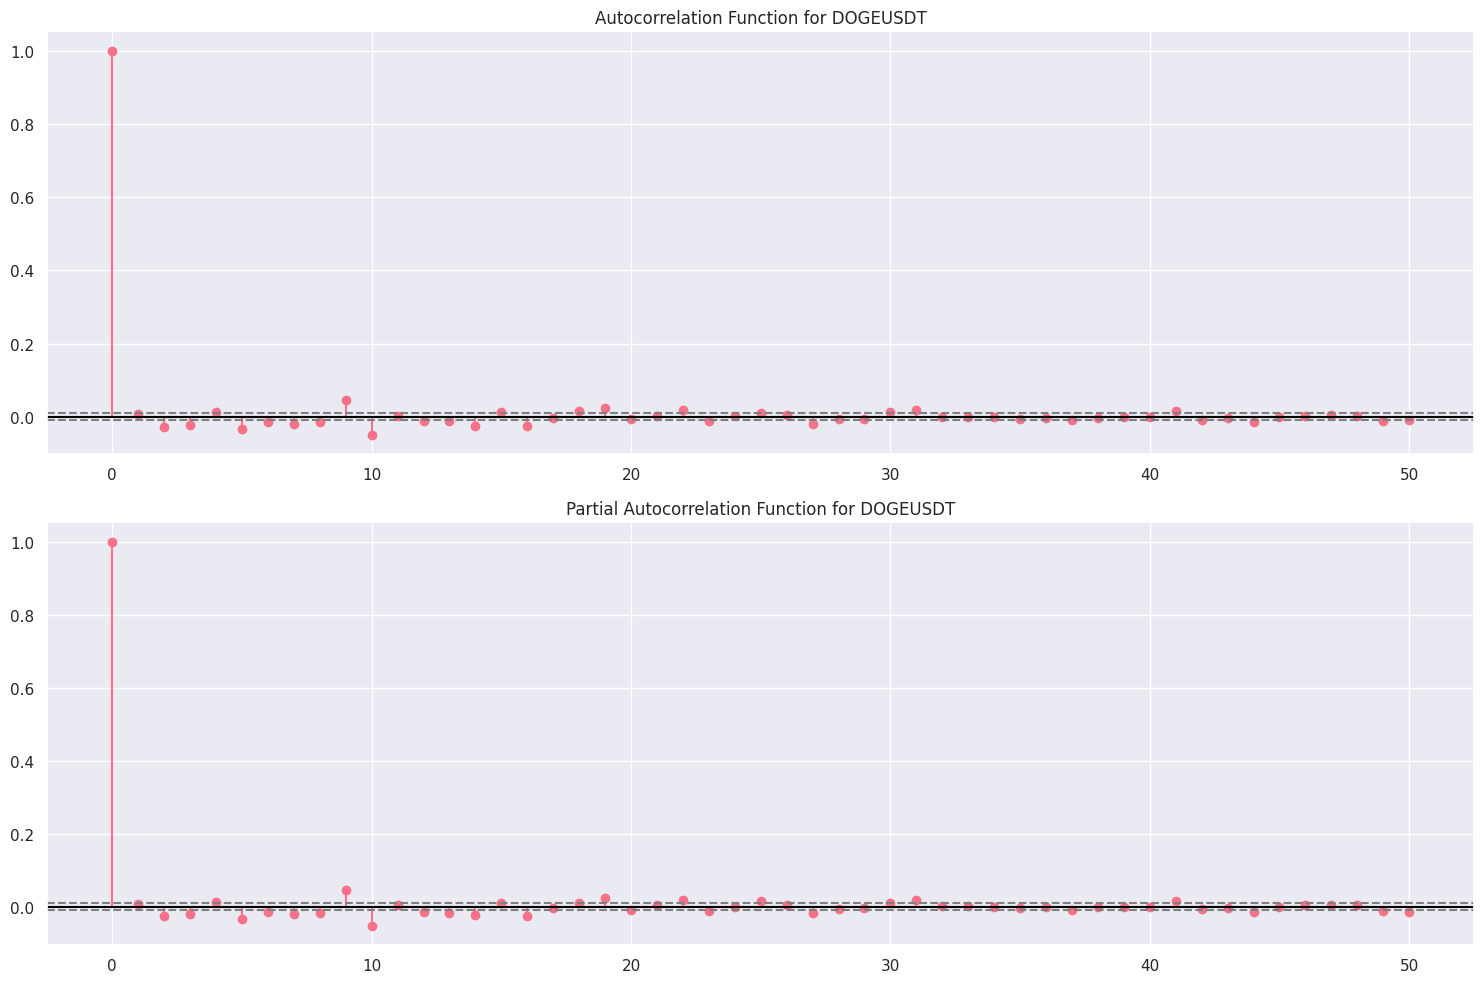


Analyzing XRPUSDT


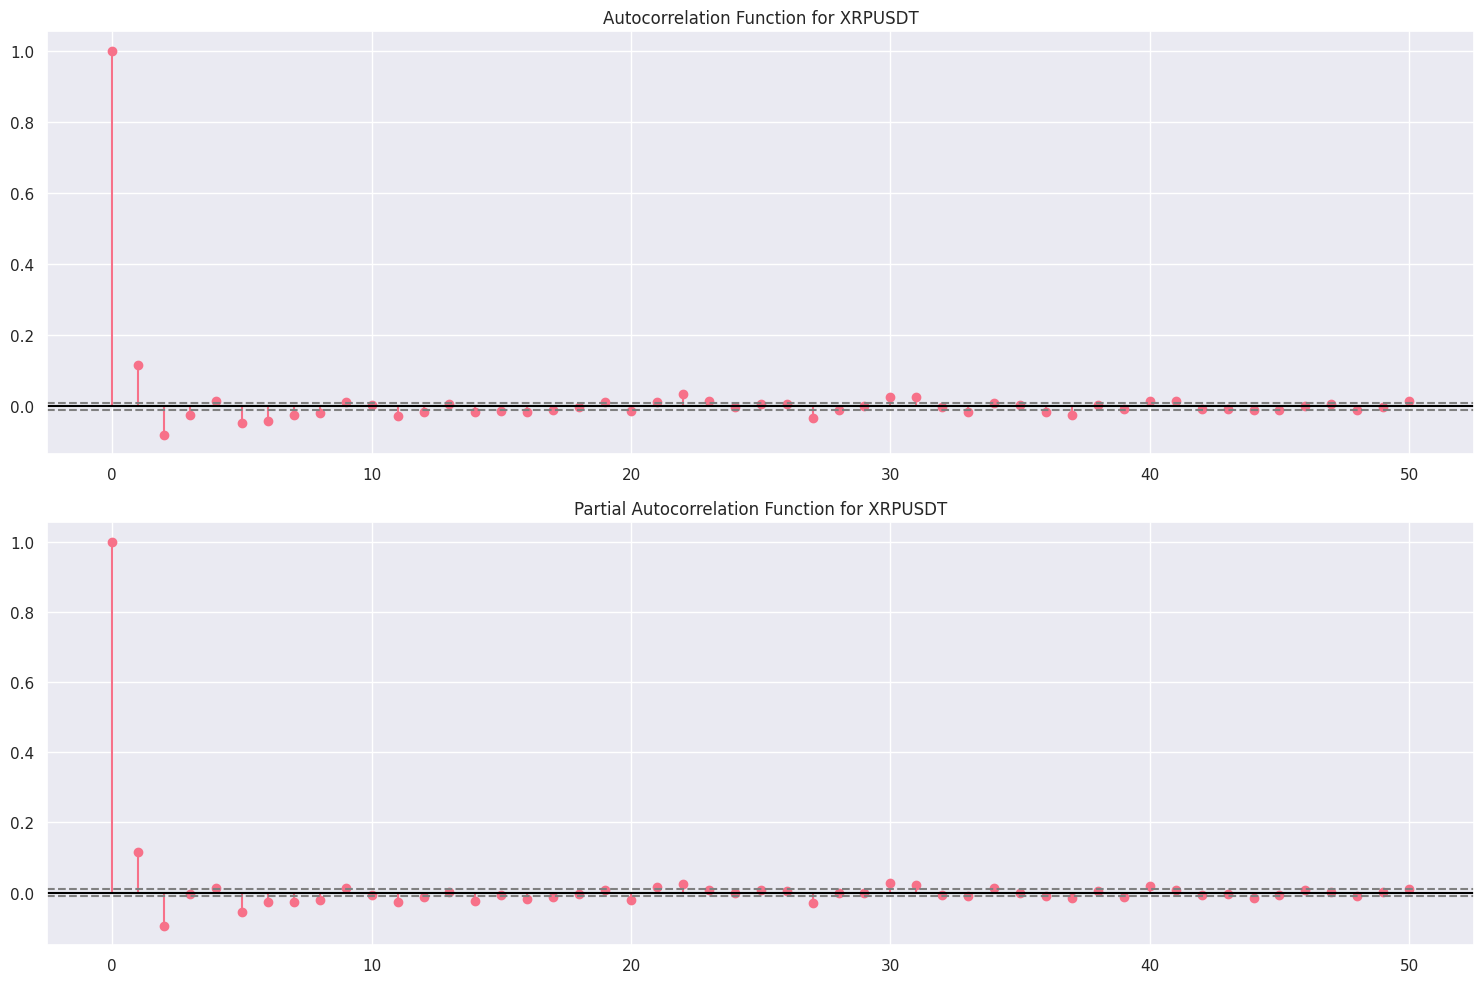


Analyzing BNBUSDT


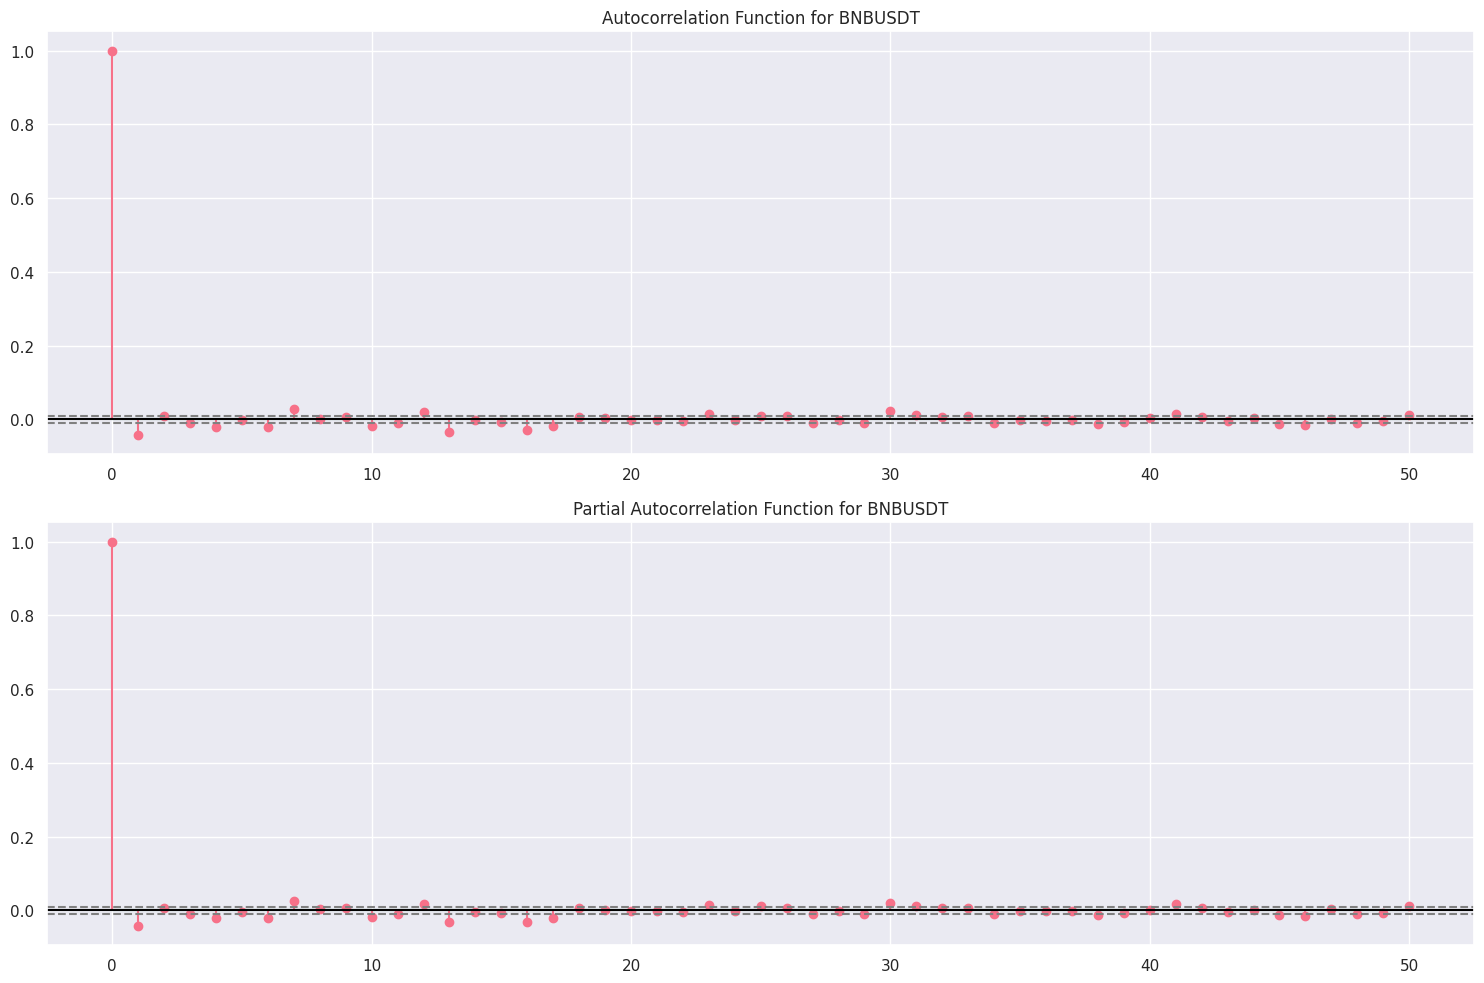


Analyzing ETHUSDT


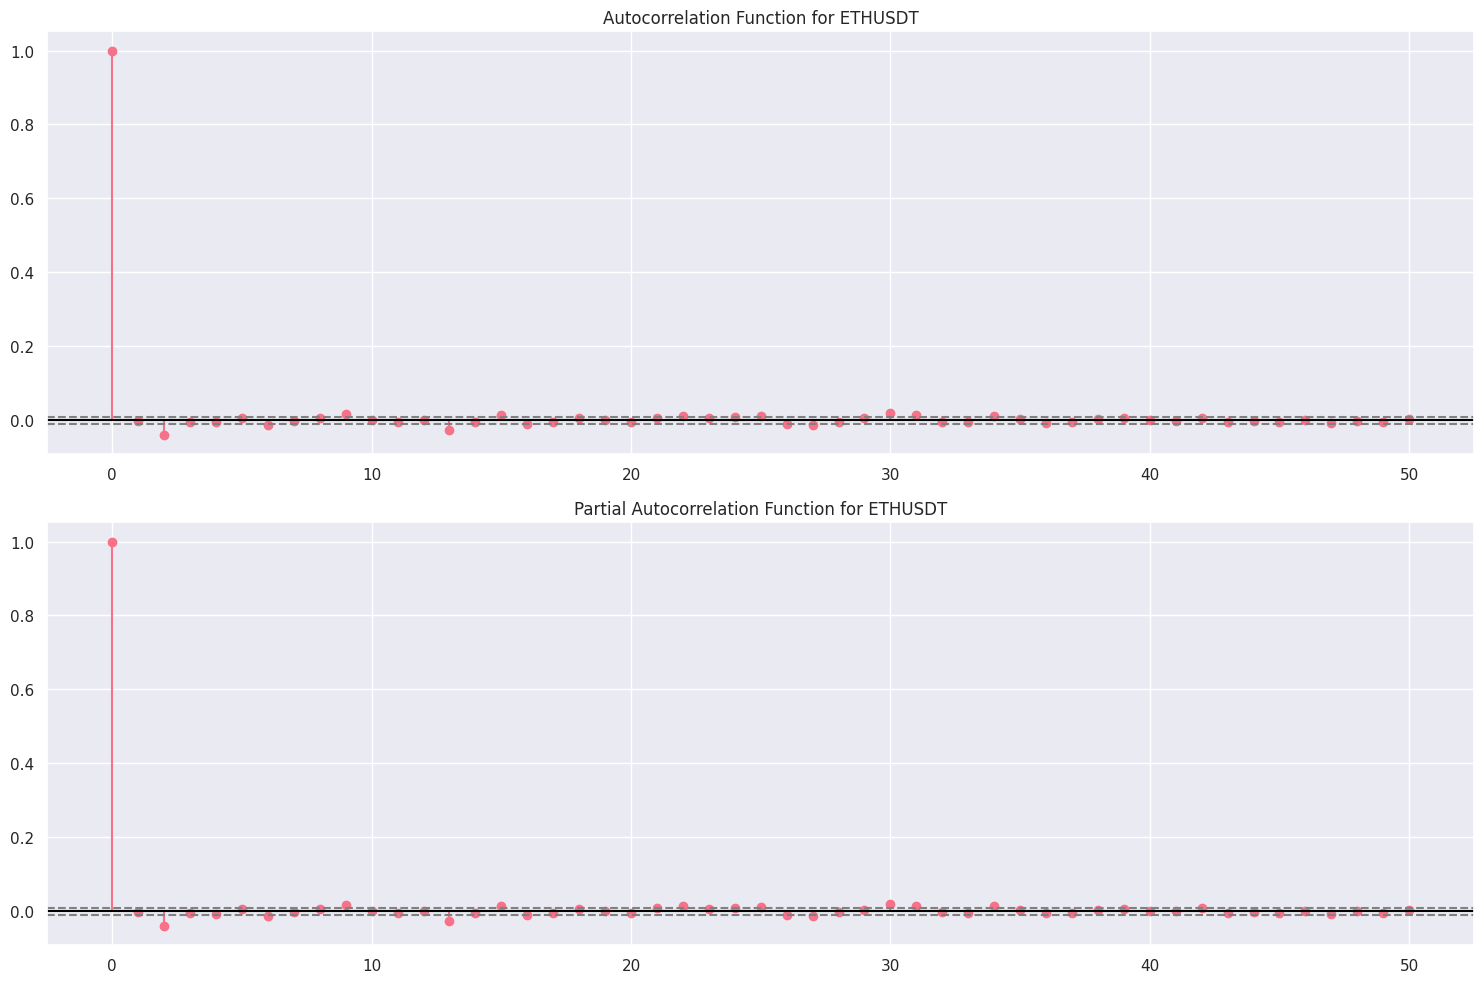

In [24]:
# Plot ACF and PACF for each crypto
for symbol in returns_data.keys():
    print(f"\nAnalyzing {symbol}")
    plot_acf_pacf(returns_data[symbol]['returns'], symbol)

## Cross-Correlation Analysis
Let's analyze the lead-lag relationships between different cryptocurrency pairs using
cross-correlation functions. This will help us understand if price movements in one
crypto tend to lead or lag another.

In [25]:
def plot_ccf(series1, series2, name1, name2, lags=50):
    ccf_values = ccf(series1.dropna(), series2.dropna(), adjusted=False)

    # Plot CCF
    plt.figure(figsize=(15, 5))
    plt.stem(range(-lags, lags + 1), ccf_values[lags - lags:lags + lags + 1])
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96 / np.sqrt(len(series1)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(series1)), linestyle='--', color='gray')
    plt.title(f'Cross-Correlation Function: {name1} vs {name2}')
    plt.xlabel('Lag')
    plt.ylabel('CCF')
    plt.tight_layout()
    plt.show()

    # Find significant lags
    threshold = 1.96 / np.sqrt(len(series1))
    significant_lags = np.where(np.abs(ccf_values) > threshold)[0] - lags
    if len(significant_lags) > 0:
        print(f"Significant lags between {name1} and {name2}:")
        for lag in significant_lags:
            if lag < 0:
                print(
                    f"{name2} leads {name1} by {abs(lag)} periods "
                    f"(correlation: {ccf_values[lag + lags]:.3f})"
                )
            elif lag > 0:
                print(
                    f"{name1} leads {name2} by {lag} periods "
                    f"(correlation: {ccf_values[lag + lags]:.3f})"
                )


Analyzing cross-correlation between SOLUSDT and ADAUSDT


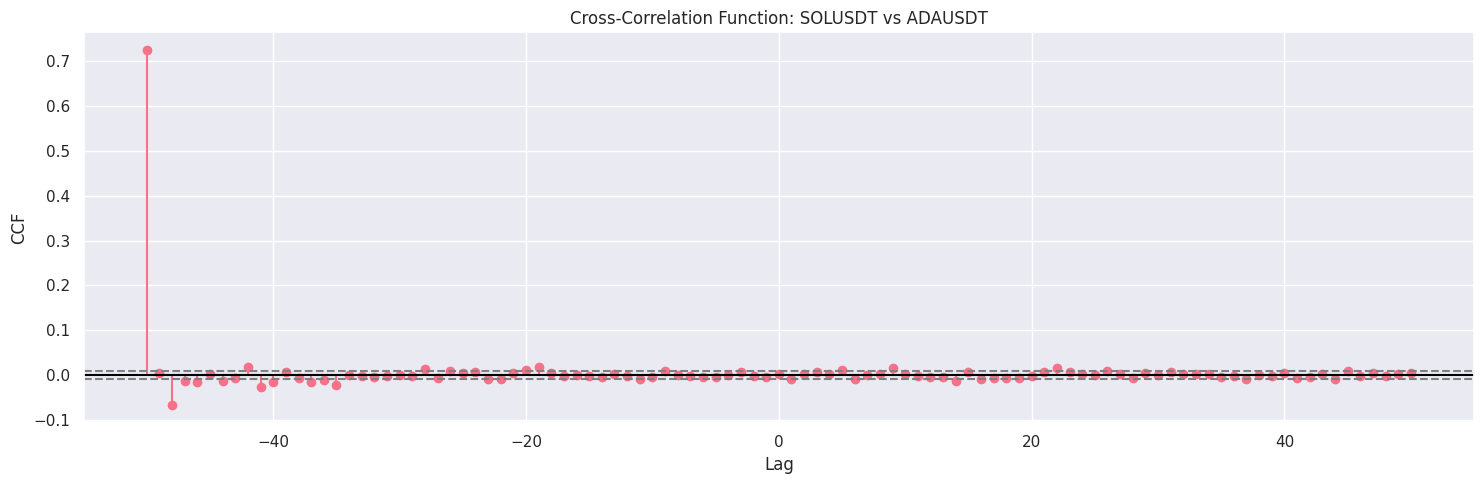

Significant lags between SOLUSDT and ADAUSDT:
ADAUSDT leads SOLUSDT by 50 periods (correlation: 0.725)
ADAUSDT leads SOLUSDT by 48 periods (correlation: -0.066)
ADAUSDT leads SOLUSDT by 47 periods (correlation: -0.013)
ADAUSDT leads SOLUSDT by 46 periods (correlation: -0.015)
ADAUSDT leads SOLUSDT by 44 periods (correlation: -0.012)
ADAUSDT leads SOLUSDT by 42 periods (correlation: 0.017)
ADAUSDT leads SOLUSDT by 41 periods (correlation: -0.027)
ADAUSDT leads SOLUSDT by 40 periods (correlation: -0.015)
ADAUSDT leads SOLUSDT by 37 periods (correlation: -0.016)
ADAUSDT leads SOLUSDT by 36 periods (correlation: -0.010)
ADAUSDT leads SOLUSDT by 35 periods (correlation: -0.022)
ADAUSDT leads SOLUSDT by 28 periods (correlation: 0.014)
ADAUSDT leads SOLUSDT by 20 periods (correlation: 0.012)
ADAUSDT leads SOLUSDT by 19 periods (correlation: 0.018)
ADAUSDT leads SOLUSDT by 11 periods (correlation: -0.010)
SOLUSDT leads ADAUSDT by 5 periods (correlation: 0.012)
SOLUSDT leads ADAUSDT by 9 period

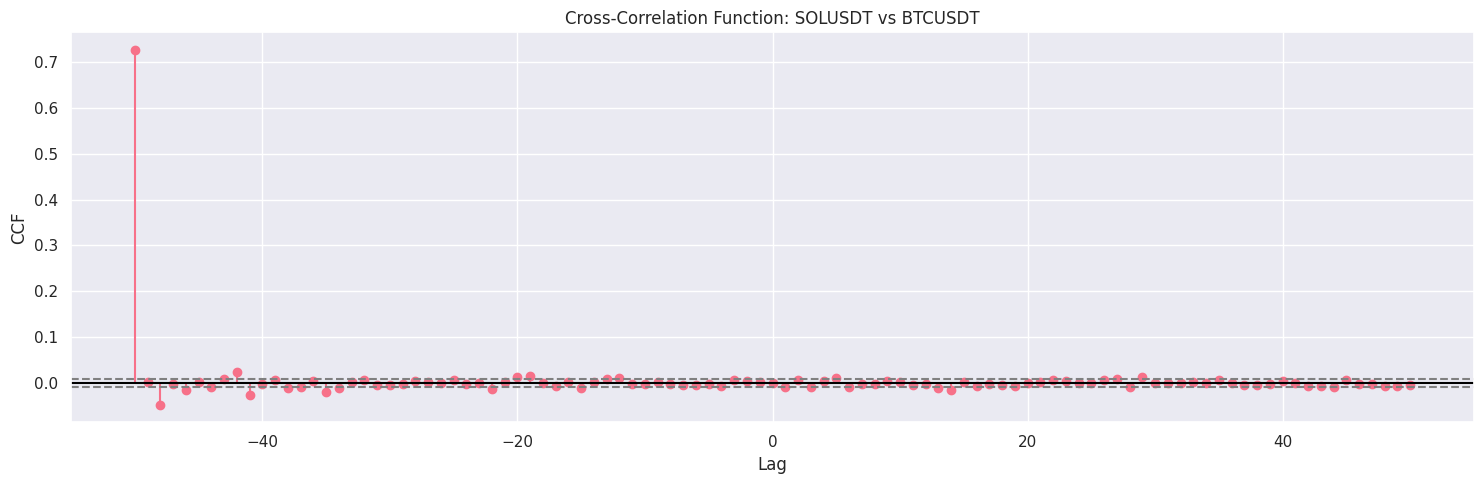

Significant lags between SOLUSDT and BTCUSDT:
BTCUSDT leads SOLUSDT by 50 periods (correlation: 0.726)
BTCUSDT leads SOLUSDT by 48 periods (correlation: -0.047)
BTCUSDT leads SOLUSDT by 46 periods (correlation: -0.014)
BTCUSDT leads SOLUSDT by 43 periods (correlation: 0.010)
BTCUSDT leads SOLUSDT by 42 periods (correlation: 0.024)
BTCUSDT leads SOLUSDT by 41 periods (correlation: -0.026)
BTCUSDT leads SOLUSDT by 38 periods (correlation: -0.010)
BTCUSDT leads SOLUSDT by 35 periods (correlation: -0.020)
BTCUSDT leads SOLUSDT by 34 periods (correlation: -0.011)
BTCUSDT leads SOLUSDT by 22 periods (correlation: -0.013)
BTCUSDT leads SOLUSDT by 20 periods (correlation: 0.012)
BTCUSDT leads SOLUSDT by 19 periods (correlation: 0.015)
BTCUSDT leads SOLUSDT by 15 periods (correlation: -0.010)
BTCUSDT leads SOLUSDT by 12 periods (correlation: 0.012)
SOLUSDT leads BTCUSDT by 1 periods (correlation: -0.010)
SOLUSDT leads BTCUSDT by 5 periods (correlation: 0.010)
SOLUSDT leads BTCUSDT by 13 periods

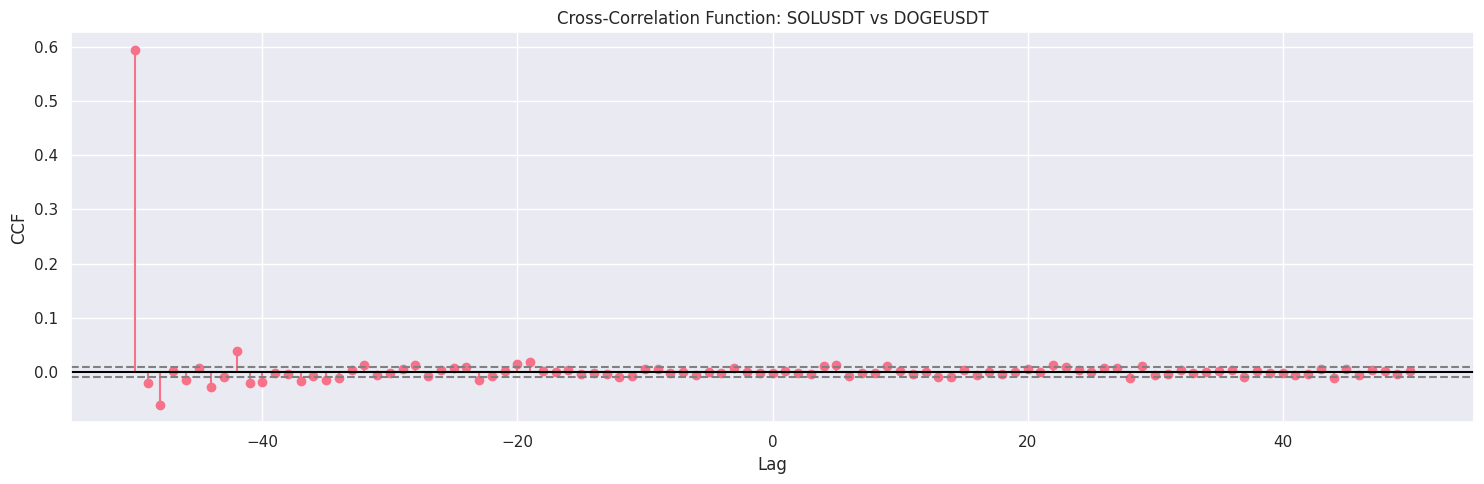

Significant lags between SOLUSDT and DOGEUSDT:
DOGEUSDT leads SOLUSDT by 50 periods (correlation: 0.594)
DOGEUSDT leads SOLUSDT by 49 periods (correlation: -0.020)
DOGEUSDT leads SOLUSDT by 48 periods (correlation: -0.060)
DOGEUSDT leads SOLUSDT by 46 periods (correlation: -0.015)
DOGEUSDT leads SOLUSDT by 44 periods (correlation: -0.029)
DOGEUSDT leads SOLUSDT by 43 periods (correlation: -0.010)
DOGEUSDT leads SOLUSDT by 42 periods (correlation: 0.039)
DOGEUSDT leads SOLUSDT by 41 periods (correlation: -0.021)
DOGEUSDT leads SOLUSDT by 40 periods (correlation: -0.020)
DOGEUSDT leads SOLUSDT by 37 periods (correlation: -0.016)
DOGEUSDT leads SOLUSDT by 35 periods (correlation: -0.015)
DOGEUSDT leads SOLUSDT by 34 periods (correlation: -0.010)
DOGEUSDT leads SOLUSDT by 32 periods (correlation: 0.013)
DOGEUSDT leads SOLUSDT by 28 periods (correlation: 0.012)
DOGEUSDT leads SOLUSDT by 23 periods (correlation: -0.016)
DOGEUSDT leads SOLUSDT by 20 periods (correlation: 0.014)
DOGEUSDT leads

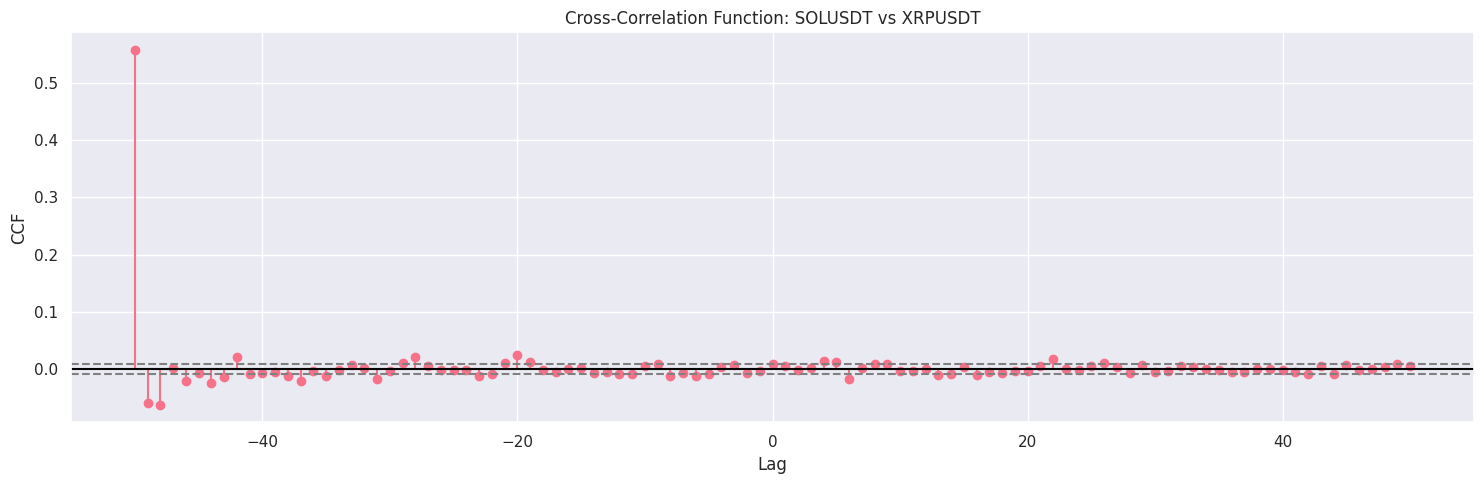

Significant lags between SOLUSDT and XRPUSDT:
XRPUSDT leads SOLUSDT by 50 periods (correlation: 0.557)
XRPUSDT leads SOLUSDT by 49 periods (correlation: -0.059)
XRPUSDT leads SOLUSDT by 48 periods (correlation: -0.062)
XRPUSDT leads SOLUSDT by 46 periods (correlation: -0.021)
XRPUSDT leads SOLUSDT by 44 periods (correlation: -0.025)
XRPUSDT leads SOLUSDT by 43 periods (correlation: -0.013)
XRPUSDT leads SOLUSDT by 42 periods (correlation: 0.021)
XRPUSDT leads SOLUSDT by 38 periods (correlation: -0.012)
XRPUSDT leads SOLUSDT by 37 periods (correlation: -0.021)
XRPUSDT leads SOLUSDT by 35 periods (correlation: -0.011)
XRPUSDT leads SOLUSDT by 31 periods (correlation: -0.017)
XRPUSDT leads SOLUSDT by 29 periods (correlation: 0.010)
XRPUSDT leads SOLUSDT by 28 periods (correlation: 0.021)
XRPUSDT leads SOLUSDT by 23 periods (correlation: -0.013)
XRPUSDT leads SOLUSDT by 21 periods (correlation: 0.011)
XRPUSDT leads SOLUSDT by 20 periods (correlation: 0.025)
XRPUSDT leads SOLUSDT by 19 peri

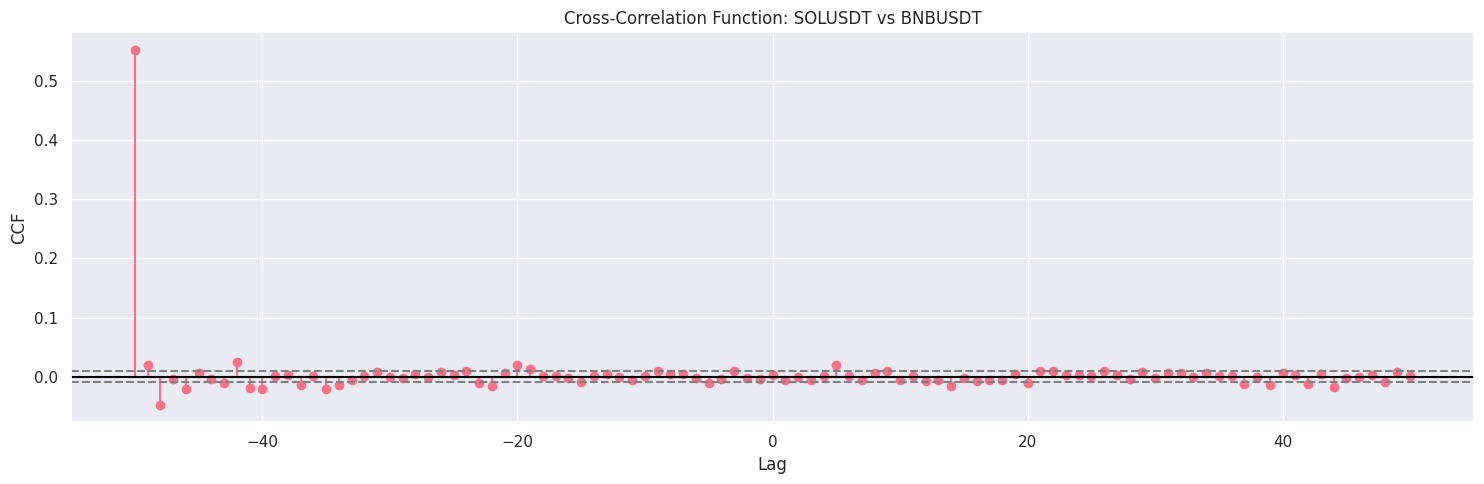

Significant lags between SOLUSDT and BNBUSDT:
BNBUSDT leads SOLUSDT by 50 periods (correlation: 0.553)
BNBUSDT leads SOLUSDT by 49 periods (correlation: 0.020)
BNBUSDT leads SOLUSDT by 48 periods (correlation: -0.047)
BNBUSDT leads SOLUSDT by 46 periods (correlation: -0.021)
BNBUSDT leads SOLUSDT by 43 periods (correlation: -0.011)
BNBUSDT leads SOLUSDT by 42 periods (correlation: 0.024)
BNBUSDT leads SOLUSDT by 41 periods (correlation: -0.018)
BNBUSDT leads SOLUSDT by 40 periods (correlation: -0.022)
BNBUSDT leads SOLUSDT by 37 periods (correlation: -0.014)
BNBUSDT leads SOLUSDT by 35 periods (correlation: -0.021)
BNBUSDT leads SOLUSDT by 34 periods (correlation: -0.015)
BNBUSDT leads SOLUSDT by 23 periods (correlation: -0.011)
BNBUSDT leads SOLUSDT by 22 periods (correlation: -0.015)
BNBUSDT leads SOLUSDT by 20 periods (correlation: 0.020)
BNBUSDT leads SOLUSDT by 19 periods (correlation: 0.013)
BNBUSDT leads SOLUSDT by 9 periods (correlation: 0.009)
BNBUSDT leads SOLUSDT by 5 period

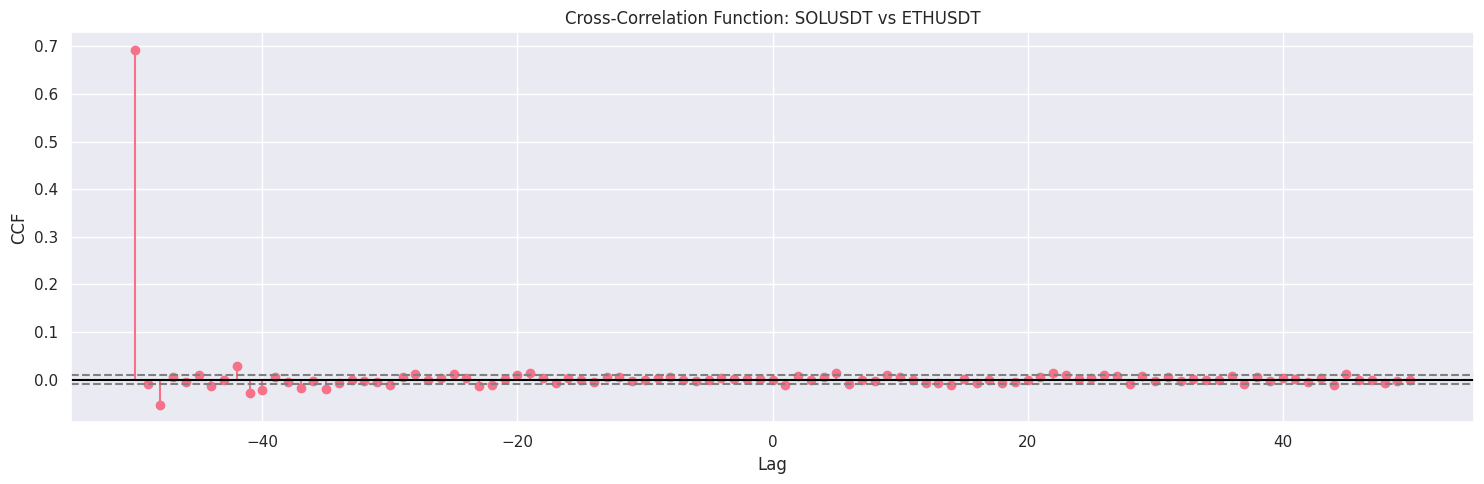

Significant lags between SOLUSDT and ETHUSDT:
ETHUSDT leads SOLUSDT by 50 periods (correlation: 0.692)
ETHUSDT leads SOLUSDT by 48 periods (correlation: -0.052)
ETHUSDT leads SOLUSDT by 45 periods (correlation: 0.009)
ETHUSDT leads SOLUSDT by 44 periods (correlation: -0.013)
ETHUSDT leads SOLUSDT by 42 periods (correlation: 0.029)
ETHUSDT leads SOLUSDT by 41 periods (correlation: -0.029)
ETHUSDT leads SOLUSDT by 40 periods (correlation: -0.021)
ETHUSDT leads SOLUSDT by 37 periods (correlation: -0.017)
ETHUSDT leads SOLUSDT by 35 periods (correlation: -0.020)
ETHUSDT leads SOLUSDT by 30 periods (correlation: -0.011)
ETHUSDT leads SOLUSDT by 28 periods (correlation: 0.012)
ETHUSDT leads SOLUSDT by 25 periods (correlation: 0.011)
ETHUSDT leads SOLUSDT by 23 periods (correlation: -0.013)
ETHUSDT leads SOLUSDT by 22 periods (correlation: -0.011)
ETHUSDT leads SOLUSDT by 20 periods (correlation: 0.009)
ETHUSDT leads SOLUSDT by 19 periods (correlation: 0.013)
SOLUSDT leads ETHUSDT by 1 period

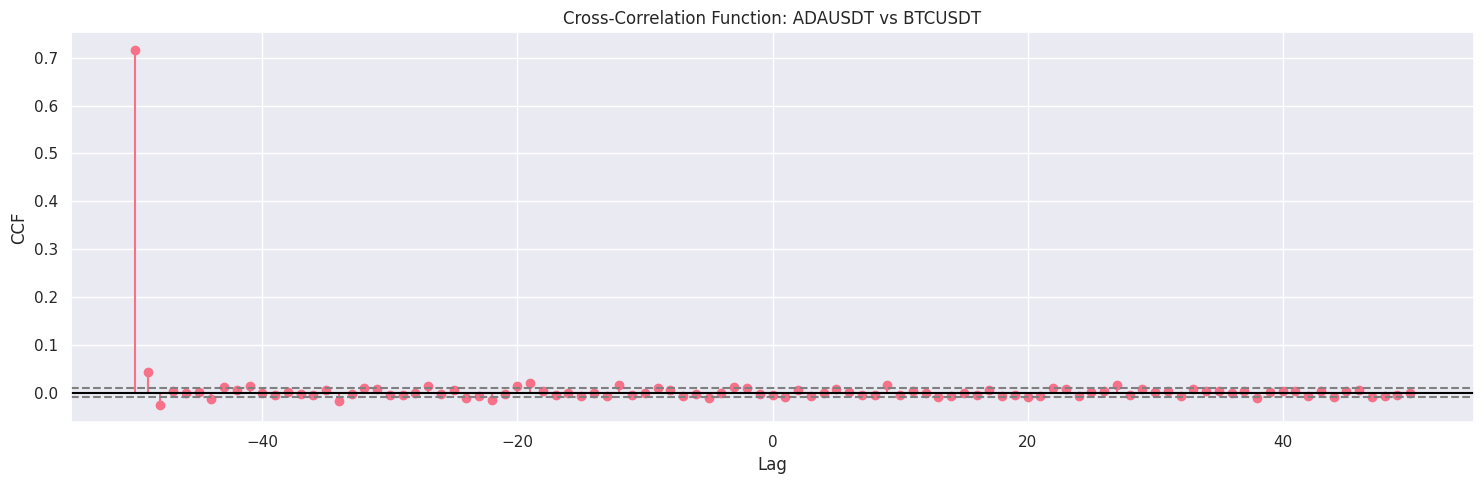

Significant lags between ADAUSDT and BTCUSDT:
BTCUSDT leads ADAUSDT by 50 periods (correlation: 0.716)
BTCUSDT leads ADAUSDT by 49 periods (correlation: 0.043)
BTCUSDT leads ADAUSDT by 48 periods (correlation: -0.025)
BTCUSDT leads ADAUSDT by 44 periods (correlation: -0.013)
BTCUSDT leads ADAUSDT by 43 periods (correlation: 0.011)
BTCUSDT leads ADAUSDT by 41 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 34 periods (correlation: -0.017)
BTCUSDT leads ADAUSDT by 27 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 24 periods (correlation: -0.011)
BTCUSDT leads ADAUSDT by 22 periods (correlation: -0.014)
BTCUSDT leads ADAUSDT by 20 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 19 periods (correlation: 0.020)
BTCUSDT leads ADAUSDT by 12 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 9 periods (correlation: 0.010)
BTCUSDT leads ADAUSDT by 5 periods (correlation: -0.012)
BTCUSDT leads ADAUSDT by 3 periods (correlation: 0.013)
ADAUSDT leads BTCUSDT by 1 periods (cor

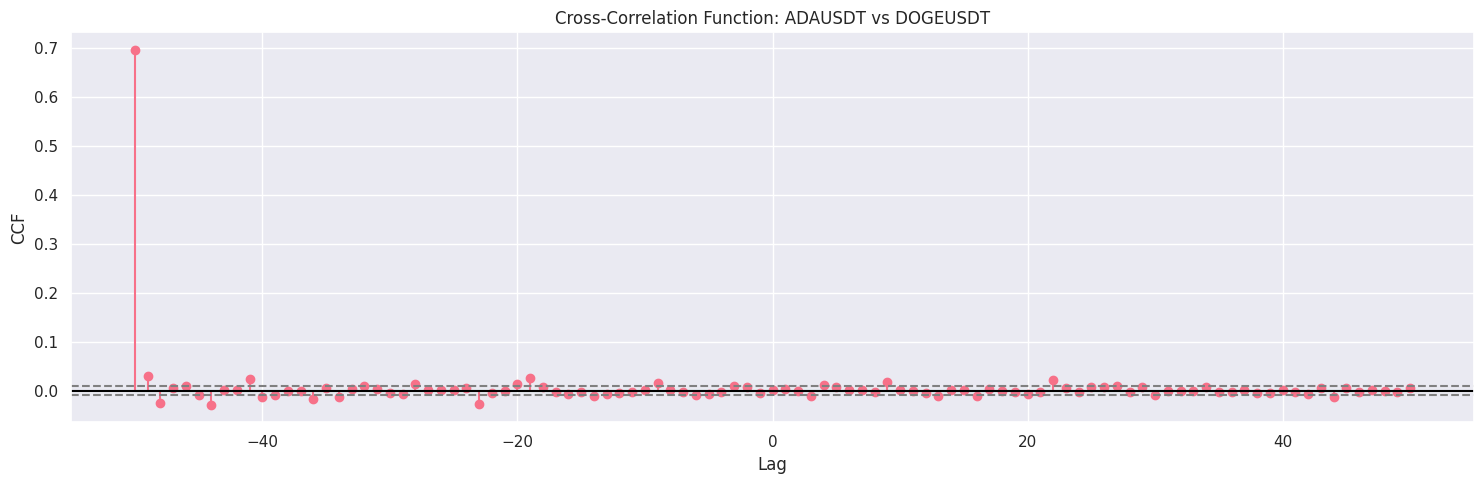

Significant lags between ADAUSDT and DOGEUSDT:
DOGEUSDT leads ADAUSDT by 50 periods (correlation: 0.696)
DOGEUSDT leads ADAUSDT by 49 periods (correlation: 0.029)
DOGEUSDT leads ADAUSDT by 48 periods (correlation: -0.025)
DOGEUSDT leads ADAUSDT by 46 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 45 periods (correlation: -0.010)
DOGEUSDT leads ADAUSDT by 44 periods (correlation: -0.029)
DOGEUSDT leads ADAUSDT by 41 periods (correlation: 0.024)
DOGEUSDT leads ADAUSDT by 40 periods (correlation: -0.013)
DOGEUSDT leads ADAUSDT by 36 periods (correlation: -0.018)
DOGEUSDT leads ADAUSDT by 34 periods (correlation: -0.014)
DOGEUSDT leads ADAUSDT by 32 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 28 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 23 periods (correlation: -0.028)
DOGEUSDT leads ADAUSDT by 20 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 19 periods (correlation: 0.025)
DOGEUSDT leads ADAUSDT by 14 periods (correlation: -0.012)
DOGEUSDT leads AD

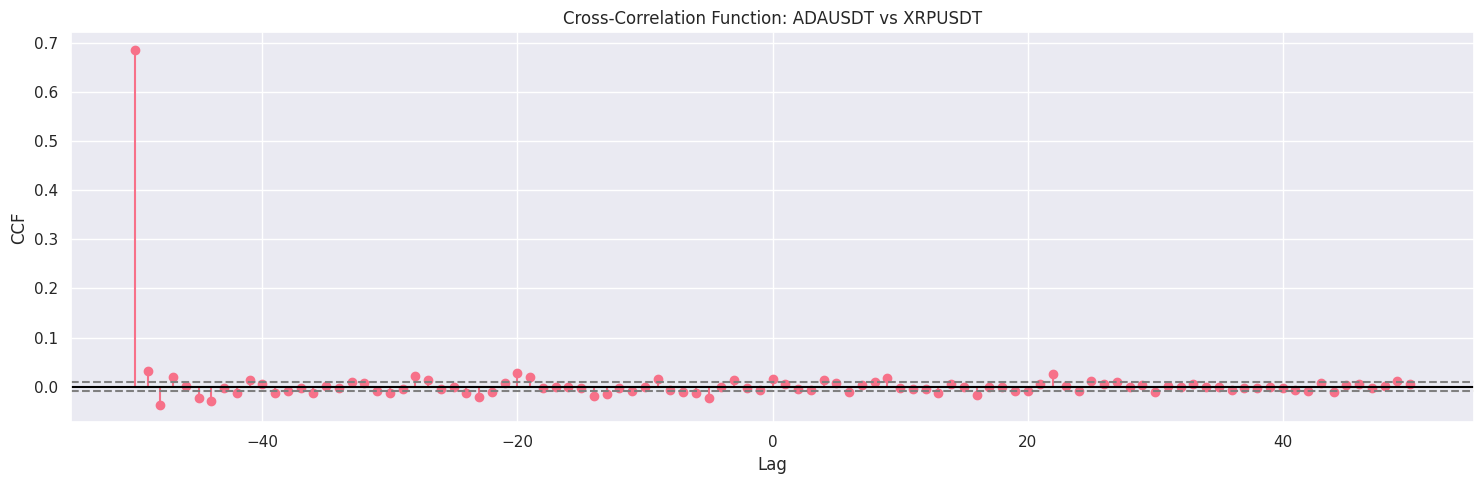

Significant lags between ADAUSDT and XRPUSDT:
XRPUSDT leads ADAUSDT by 50 periods (correlation: 0.685)
XRPUSDT leads ADAUSDT by 49 periods (correlation: 0.031)
XRPUSDT leads ADAUSDT by 48 periods (correlation: -0.036)
XRPUSDT leads ADAUSDT by 47 periods (correlation: 0.020)
XRPUSDT leads ADAUSDT by 45 periods (correlation: -0.024)
XRPUSDT leads ADAUSDT by 44 periods (correlation: -0.028)
XRPUSDT leads ADAUSDT by 42 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 41 periods (correlation: 0.013)
XRPUSDT leads ADAUSDT by 39 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 38 periods (correlation: -0.010)
XRPUSDT leads ADAUSDT by 36 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 30 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 28 periods (correlation: 0.022)
XRPUSDT leads ADAUSDT by 27 periods (correlation: 0.014)
XRPUSDT leads ADAUSDT by 24 periods (correlation: -0.012)
XRPUSDT leads ADAUSDT by 23 periods (correlation: -0.020)
XRPUSDT leads ADAUSDT by 22 peri

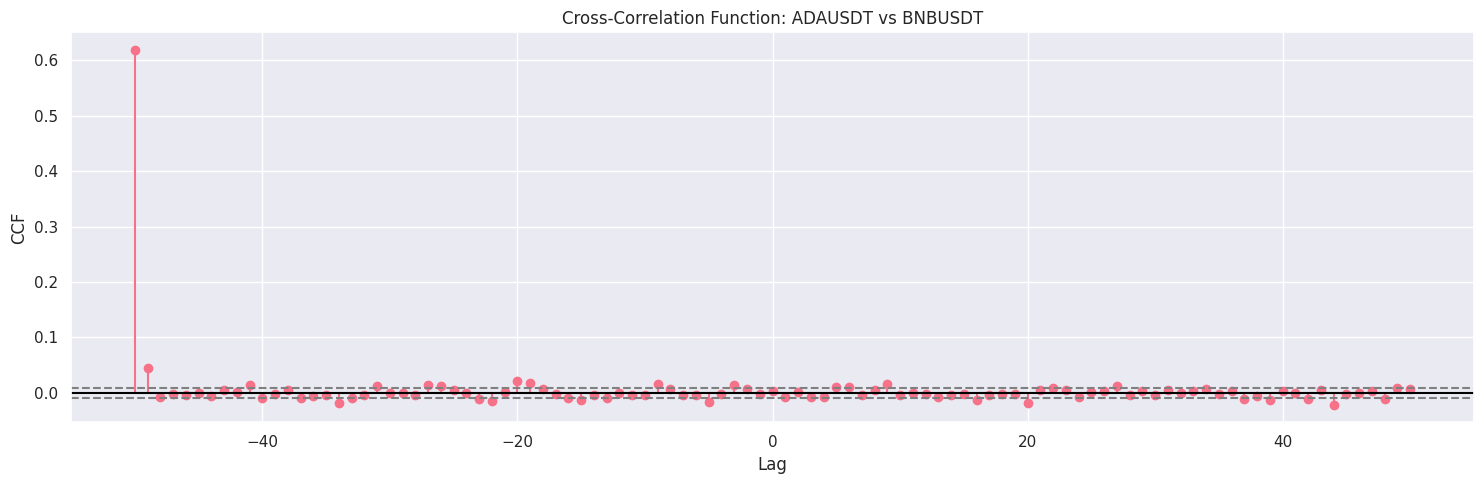

Significant lags between ADAUSDT and BNBUSDT:
BNBUSDT leads ADAUSDT by 50 periods (correlation: 0.618)
BNBUSDT leads ADAUSDT by 49 periods (correlation: 0.045)
BNBUSDT leads ADAUSDT by 41 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 34 periods (correlation: -0.018)
BNBUSDT leads ADAUSDT by 31 periods (correlation: 0.012)
BNBUSDT leads ADAUSDT by 27 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 26 periods (correlation: 0.013)
BNBUSDT leads ADAUSDT by 23 periods (correlation: -0.011)
BNBUSDT leads ADAUSDT by 22 periods (correlation: -0.014)
BNBUSDT leads ADAUSDT by 20 periods (correlation: 0.021)
BNBUSDT leads ADAUSDT by 19 periods (correlation: 0.017)
BNBUSDT leads ADAUSDT by 16 periods (correlation: -0.010)
BNBUSDT leads ADAUSDT by 15 periods (correlation: -0.012)
BNBUSDT leads ADAUSDT by 9 periods (correlation: 0.016)
BNBUSDT leads ADAUSDT by 5 periods (correlation: -0.017)
BNBUSDT leads ADAUSDT by 3 periods (correlation: 0.014)
ADAUSDT leads BNBUSDT by 5 periods (cor

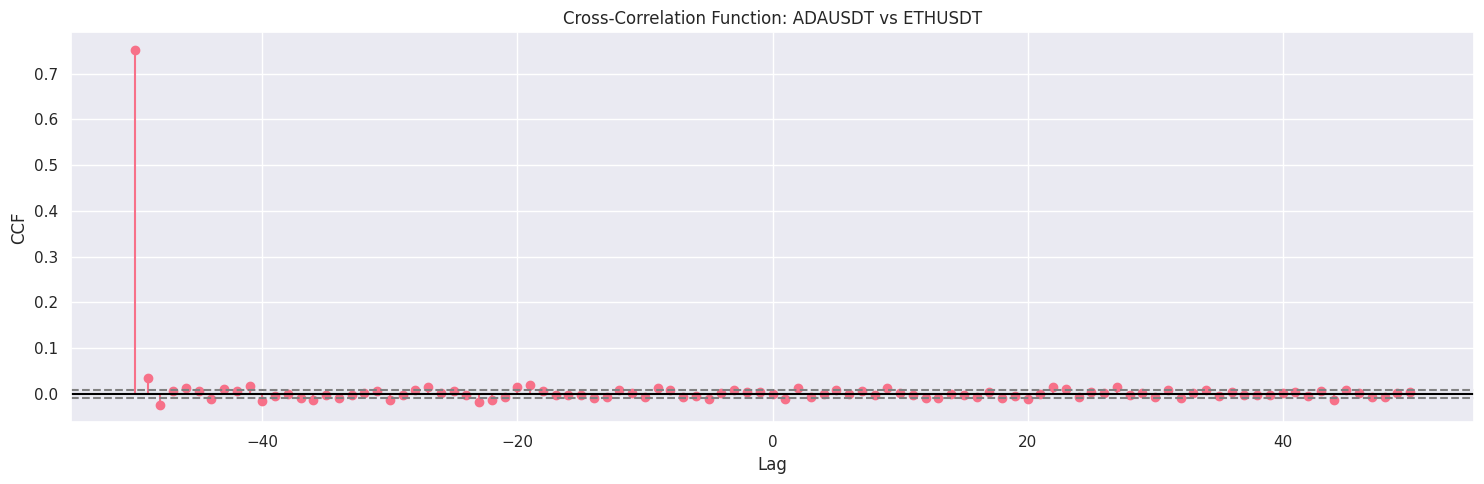

Significant lags between ADAUSDT and ETHUSDT:
ETHUSDT leads ADAUSDT by 50 periods (correlation: 0.752)
ETHUSDT leads ADAUSDT by 49 periods (correlation: 0.036)
ETHUSDT leads ADAUSDT by 48 periods (correlation: -0.023)
ETHUSDT leads ADAUSDT by 46 periods (correlation: 0.013)
ETHUSDT leads ADAUSDT by 44 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 43 periods (correlation: 0.012)
ETHUSDT leads ADAUSDT by 41 periods (correlation: 0.017)
ETHUSDT leads ADAUSDT by 40 periods (correlation: -0.016)
ETHUSDT leads ADAUSDT by 36 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 34 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 30 periods (correlation: -0.013)
ETHUSDT leads ADAUSDT by 27 periods (correlation: 0.015)
ETHUSDT leads ADAUSDT by 23 periods (correlation: -0.017)
ETHUSDT leads ADAUSDT by 22 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 20 periods (correlation: 0.014)
ETHUSDT leads ADAUSDT by 19 periods (correlation: 0.020)
ETHUSDT leads ADAUSDT by 9 periods

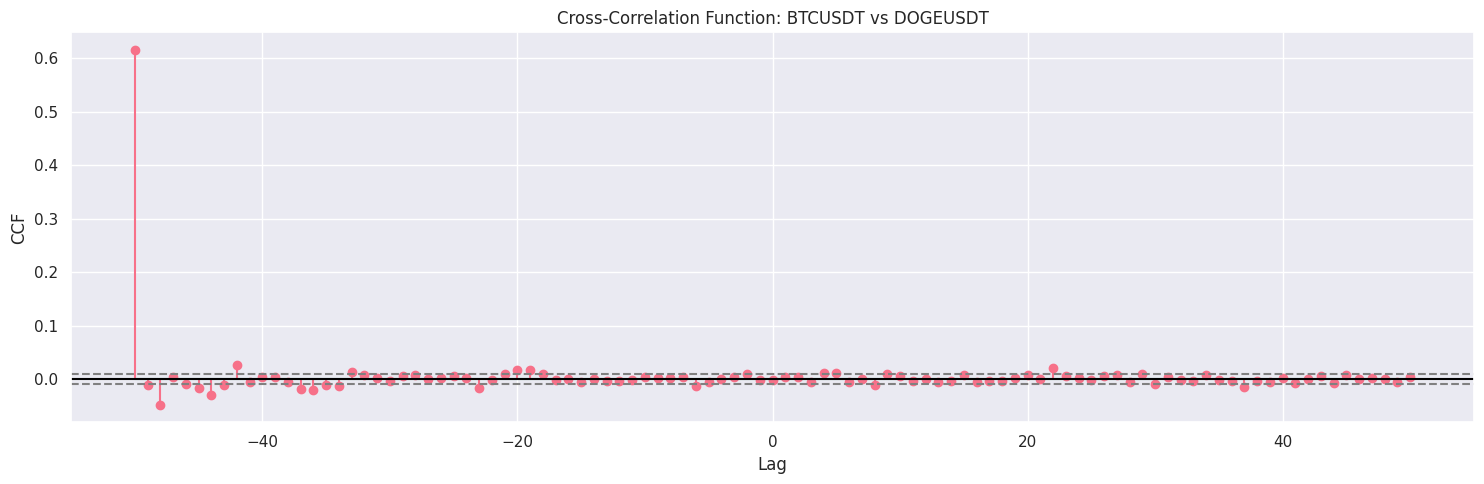

Significant lags between BTCUSDT and DOGEUSDT:
DOGEUSDT leads BTCUSDT by 50 periods (correlation: 0.615)
DOGEUSDT leads BTCUSDT by 49 periods (correlation: -0.012)
DOGEUSDT leads BTCUSDT by 48 periods (correlation: -0.048)
DOGEUSDT leads BTCUSDT by 46 periods (correlation: -0.010)
DOGEUSDT leads BTCUSDT by 45 periods (correlation: -0.016)
DOGEUSDT leads BTCUSDT by 44 periods (correlation: -0.029)
DOGEUSDT leads BTCUSDT by 43 periods (correlation: -0.012)
DOGEUSDT leads BTCUSDT by 42 periods (correlation: 0.027)
DOGEUSDT leads BTCUSDT by 37 periods (correlation: -0.019)
DOGEUSDT leads BTCUSDT by 36 periods (correlation: -0.020)
DOGEUSDT leads BTCUSDT by 35 periods (correlation: -0.011)
DOGEUSDT leads BTCUSDT by 34 periods (correlation: -0.013)
DOGEUSDT leads BTCUSDT by 33 periods (correlation: 0.014)
DOGEUSDT leads BTCUSDT by 23 periods (correlation: -0.018)
DOGEUSDT leads BTCUSDT by 20 periods (correlation: 0.017)
DOGEUSDT leads BTCUSDT by 19 periods (correlation: 0.017)
DOGEUSDT leads

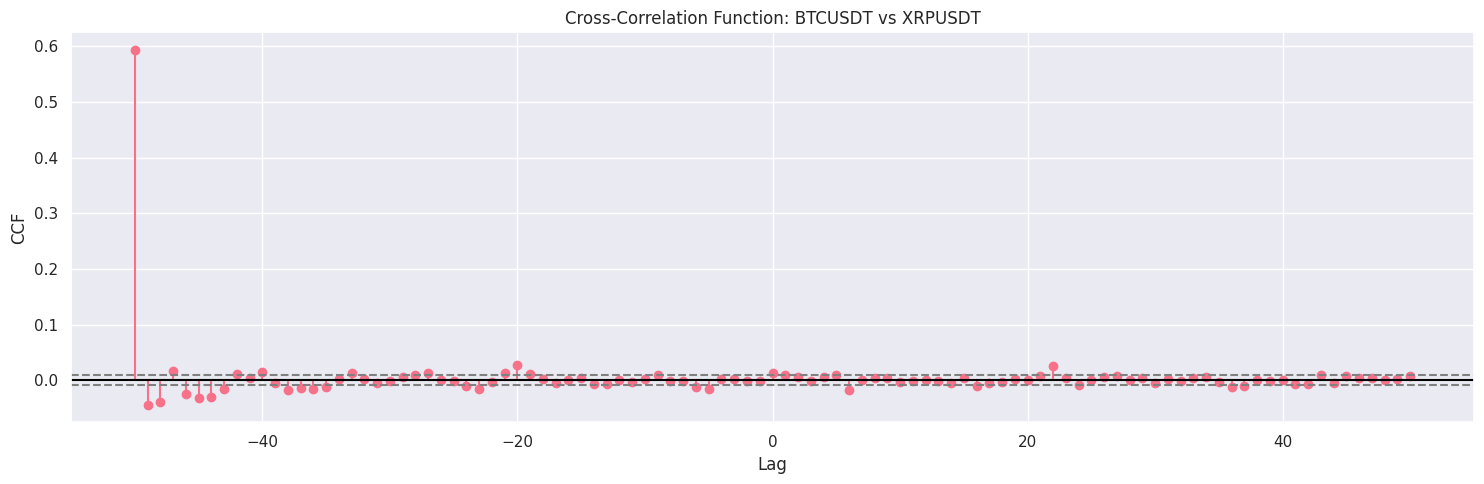

Significant lags between BTCUSDT and XRPUSDT:
XRPUSDT leads BTCUSDT by 50 periods (correlation: 0.593)
XRPUSDT leads BTCUSDT by 49 periods (correlation: -0.044)
XRPUSDT leads BTCUSDT by 48 periods (correlation: -0.038)
XRPUSDT leads BTCUSDT by 47 periods (correlation: 0.016)
XRPUSDT leads BTCUSDT by 46 periods (correlation: -0.025)
XRPUSDT leads BTCUSDT by 45 periods (correlation: -0.032)
XRPUSDT leads BTCUSDT by 44 periods (correlation: -0.030)
XRPUSDT leads BTCUSDT by 43 periods (correlation: -0.016)
XRPUSDT leads BTCUSDT by 42 periods (correlation: 0.011)
XRPUSDT leads BTCUSDT by 40 periods (correlation: 0.015)
XRPUSDT leads BTCUSDT by 38 periods (correlation: -0.017)
XRPUSDT leads BTCUSDT by 37 periods (correlation: -0.014)
XRPUSDT leads BTCUSDT by 36 periods (correlation: -0.016)
XRPUSDT leads BTCUSDT by 35 periods (correlation: -0.012)
XRPUSDT leads BTCUSDT by 33 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 28 periods (correlation: 0.009)
XRPUSDT leads BTCUSDT by 27 peri

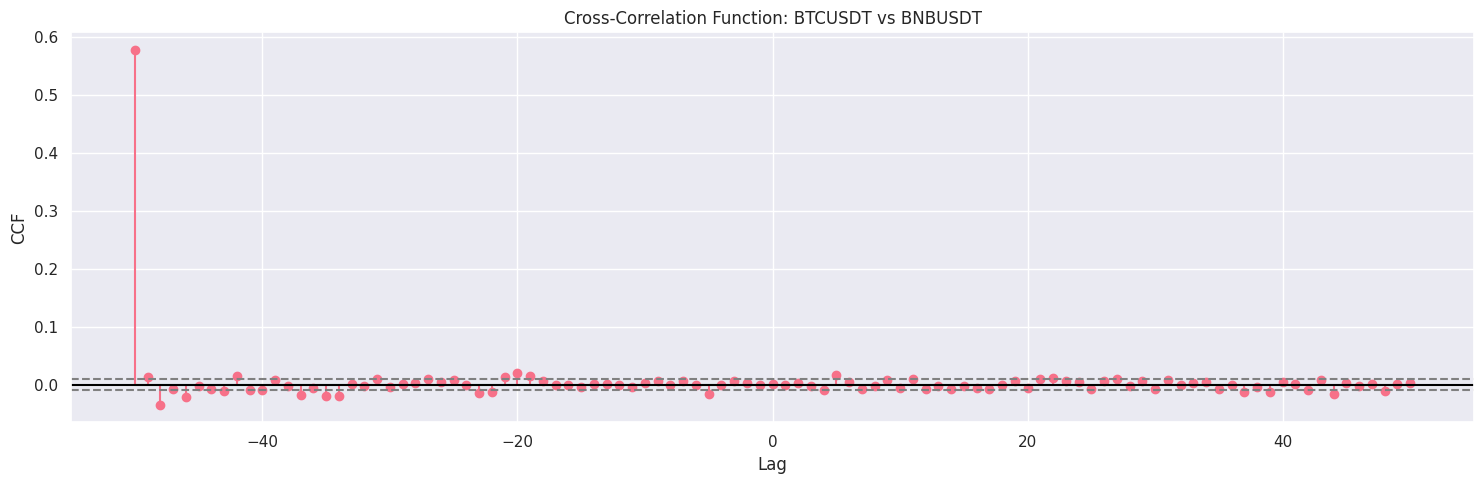

Significant lags between BTCUSDT and BNBUSDT:
BNBUSDT leads BTCUSDT by 50 periods (correlation: 0.578)
BNBUSDT leads BTCUSDT by 49 periods (correlation: 0.013)
BNBUSDT leads BTCUSDT by 48 periods (correlation: -0.034)
BNBUSDT leads BTCUSDT by 46 periods (correlation: -0.022)
BNBUSDT leads BTCUSDT by 43 periods (correlation: -0.011)
BNBUSDT leads BTCUSDT by 42 periods (correlation: 0.016)
BNBUSDT leads BTCUSDT by 37 periods (correlation: -0.017)
BNBUSDT leads BTCUSDT by 35 periods (correlation: -0.019)
BNBUSDT leads BTCUSDT by 34 periods (correlation: -0.019)
BNBUSDT leads BTCUSDT by 31 periods (correlation: 0.009)
BNBUSDT leads BTCUSDT by 27 periods (correlation: 0.010)
BNBUSDT leads BTCUSDT by 23 periods (correlation: -0.015)
BNBUSDT leads BTCUSDT by 22 periods (correlation: -0.012)
BNBUSDT leads BTCUSDT by 21 periods (correlation: 0.013)
BNBUSDT leads BTCUSDT by 20 periods (correlation: 0.021)
BNBUSDT leads BTCUSDT by 19 periods (correlation: 0.015)
BNBUSDT leads BTCUSDT by 5 periods

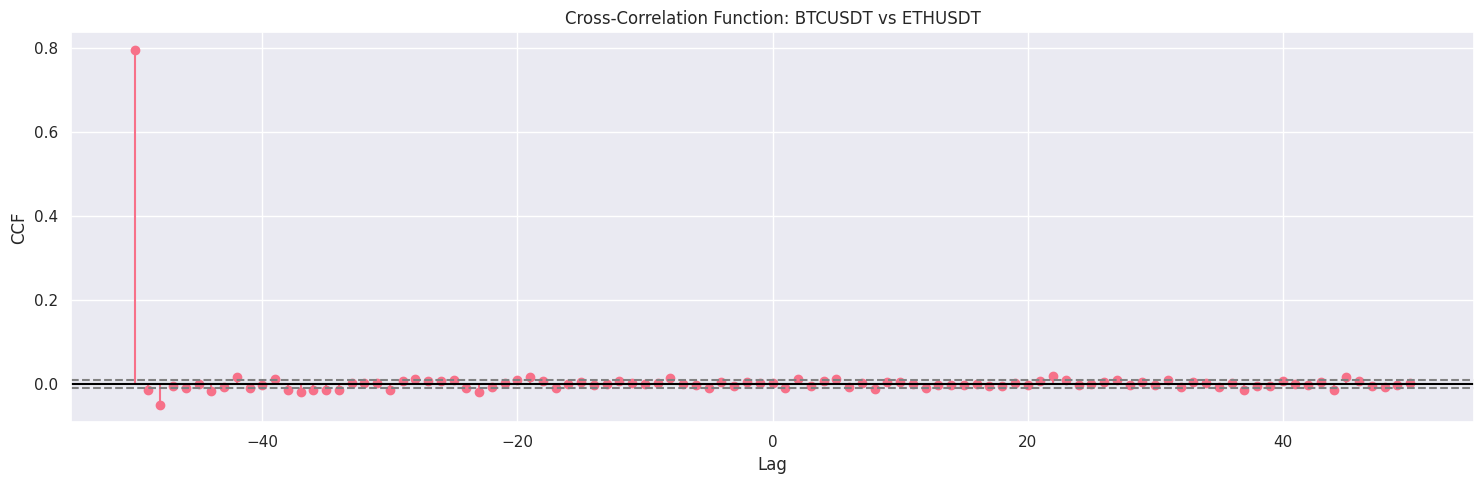

Significant lags between BTCUSDT and ETHUSDT:
ETHUSDT leads BTCUSDT by 50 periods (correlation: 0.796)
ETHUSDT leads BTCUSDT by 49 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 48 periods (correlation: -0.049)
ETHUSDT leads BTCUSDT by 46 periods (correlation: -0.011)
ETHUSDT leads BTCUSDT by 44 periods (correlation: -0.018)
ETHUSDT leads BTCUSDT by 42 periods (correlation: 0.016)
ETHUSDT leads BTCUSDT by 41 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 39 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 38 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 37 periods (correlation: -0.019)
ETHUSDT leads BTCUSDT by 36 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 35 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 34 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 30 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 28 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 24 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 23 pe

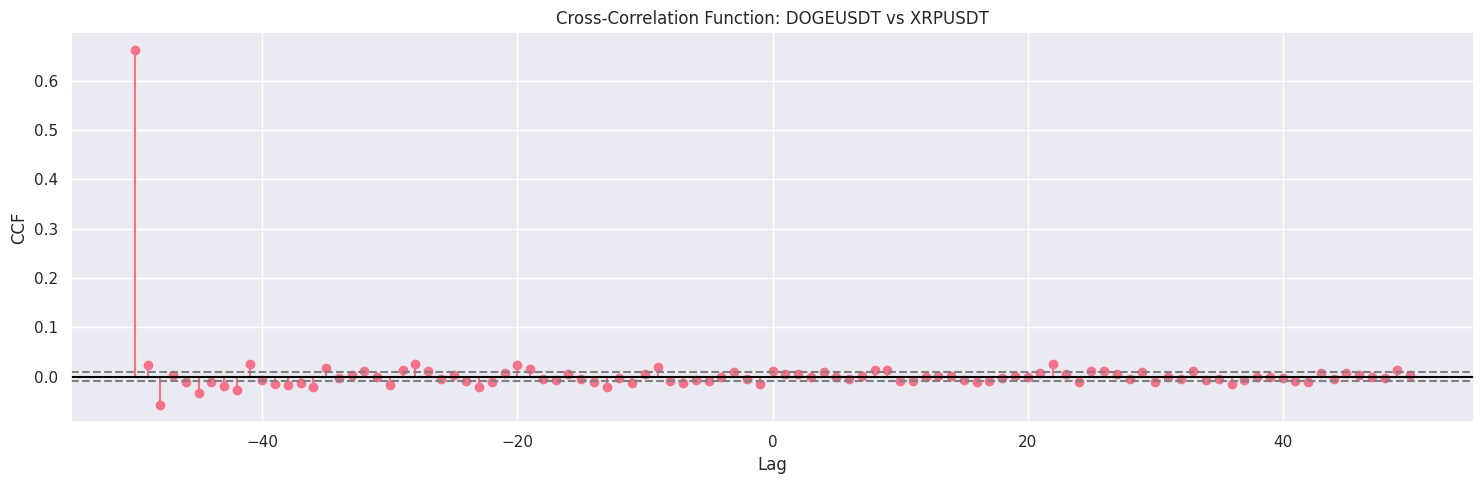

Significant lags between DOGEUSDT and XRPUSDT:
XRPUSDT leads DOGEUSDT by 50 periods (correlation: 0.662)
XRPUSDT leads DOGEUSDT by 49 periods (correlation: 0.024)
XRPUSDT leads DOGEUSDT by 48 periods (correlation: -0.056)
XRPUSDT leads DOGEUSDT by 46 periods (correlation: -0.010)
XRPUSDT leads DOGEUSDT by 45 periods (correlation: -0.034)
XRPUSDT leads DOGEUSDT by 44 periods (correlation: -0.010)
XRPUSDT leads DOGEUSDT by 43 periods (correlation: -0.018)
XRPUSDT leads DOGEUSDT by 42 periods (correlation: -0.027)
XRPUSDT leads DOGEUSDT by 41 periods (correlation: 0.027)
XRPUSDT leads DOGEUSDT by 39 periods (correlation: -0.014)
XRPUSDT leads DOGEUSDT by 38 periods (correlation: -0.017)
XRPUSDT leads DOGEUSDT by 37 periods (correlation: -0.013)
XRPUSDT leads DOGEUSDT by 36 periods (correlation: -0.020)
XRPUSDT leads DOGEUSDT by 35 periods (correlation: 0.018)
XRPUSDT leads DOGEUSDT by 32 periods (correlation: 0.011)
XRPUSDT leads DOGEUSDT by 30 periods (correlation: -0.017)
XRPUSDT leads 

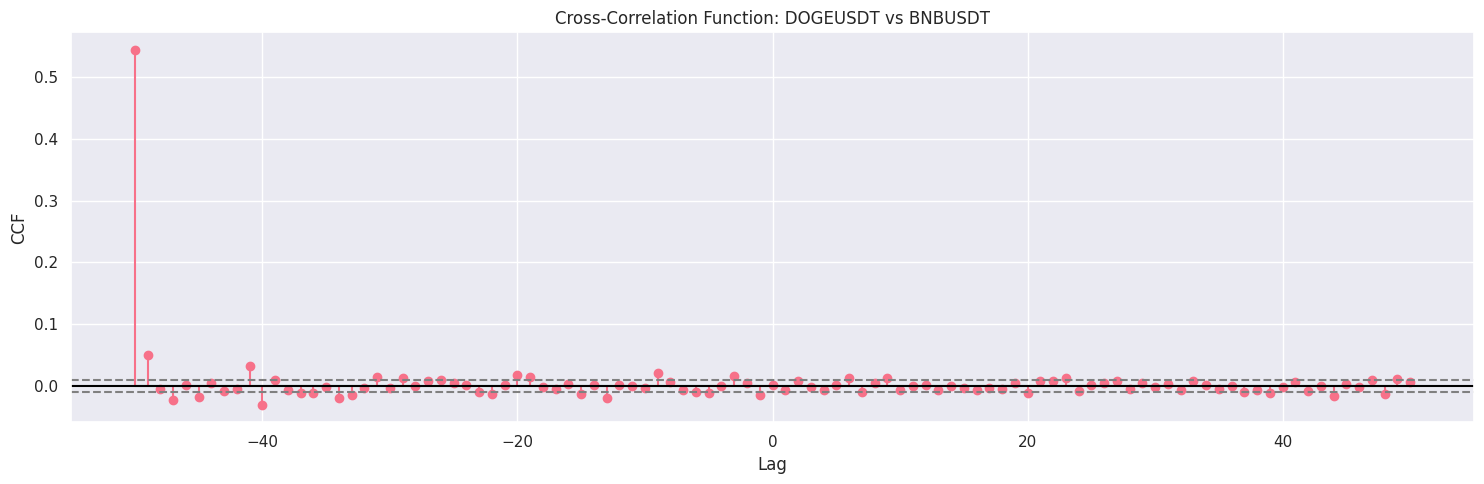

Significant lags between DOGEUSDT and BNBUSDT:
BNBUSDT leads DOGEUSDT by 50 periods (correlation: 0.543)
BNBUSDT leads DOGEUSDT by 49 periods (correlation: 0.050)
BNBUSDT leads DOGEUSDT by 47 periods (correlation: -0.022)
BNBUSDT leads DOGEUSDT by 45 periods (correlation: -0.018)
BNBUSDT leads DOGEUSDT by 41 periods (correlation: 0.032)
BNBUSDT leads DOGEUSDT by 40 periods (correlation: -0.030)
BNBUSDT leads DOGEUSDT by 37 periods (correlation: -0.012)
BNBUSDT leads DOGEUSDT by 36 periods (correlation: -0.011)
BNBUSDT leads DOGEUSDT by 34 periods (correlation: -0.020)
BNBUSDT leads DOGEUSDT by 33 periods (correlation: -0.015)
BNBUSDT leads DOGEUSDT by 31 periods (correlation: 0.016)
BNBUSDT leads DOGEUSDT by 29 periods (correlation: 0.013)
BNBUSDT leads DOGEUSDT by 26 periods (correlation: 0.010)
BNBUSDT leads DOGEUSDT by 22 periods (correlation: -0.013)
BNBUSDT leads DOGEUSDT by 20 periods (correlation: 0.018)
BNBUSDT leads DOGEUSDT by 19 periods (correlation: 0.015)
BNBUSDT leads DOG

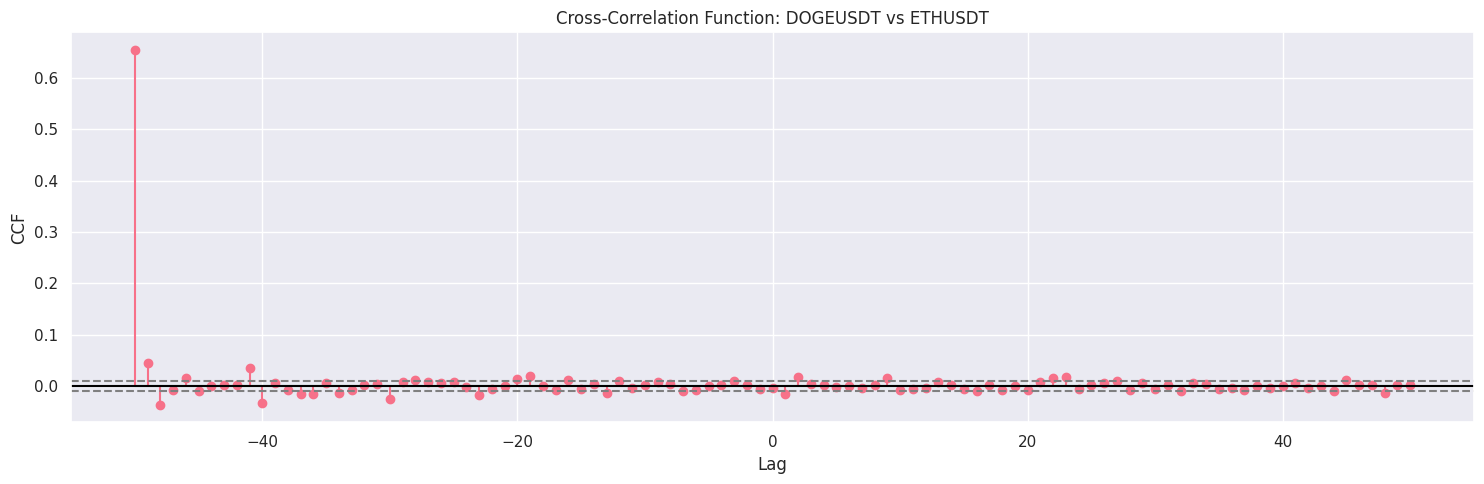

Significant lags between DOGEUSDT and ETHUSDT:
ETHUSDT leads DOGEUSDT by 50 periods (correlation: 0.654)
ETHUSDT leads DOGEUSDT by 49 periods (correlation: 0.045)
ETHUSDT leads DOGEUSDT by 48 periods (correlation: -0.036)
ETHUSDT leads DOGEUSDT by 46 periods (correlation: 0.016)
ETHUSDT leads DOGEUSDT by 45 periods (correlation: -0.009)
ETHUSDT leads DOGEUSDT by 41 periods (correlation: 0.035)
ETHUSDT leads DOGEUSDT by 40 periods (correlation: -0.032)
ETHUSDT leads DOGEUSDT by 37 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 36 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 34 periods (correlation: -0.013)
ETHUSDT leads DOGEUSDT by 30 periods (correlation: -0.025)
ETHUSDT leads DOGEUSDT by 28 periods (correlation: 0.012)
ETHUSDT leads DOGEUSDT by 23 periods (correlation: -0.018)
ETHUSDT leads DOGEUSDT by 20 periods (correlation: 0.014)
ETHUSDT leads DOGEUSDT by 19 periods (correlation: 0.021)
ETHUSDT leads DOGEUSDT by 16 periods (correlation: 0.013)
ETHUSDT leads DOG

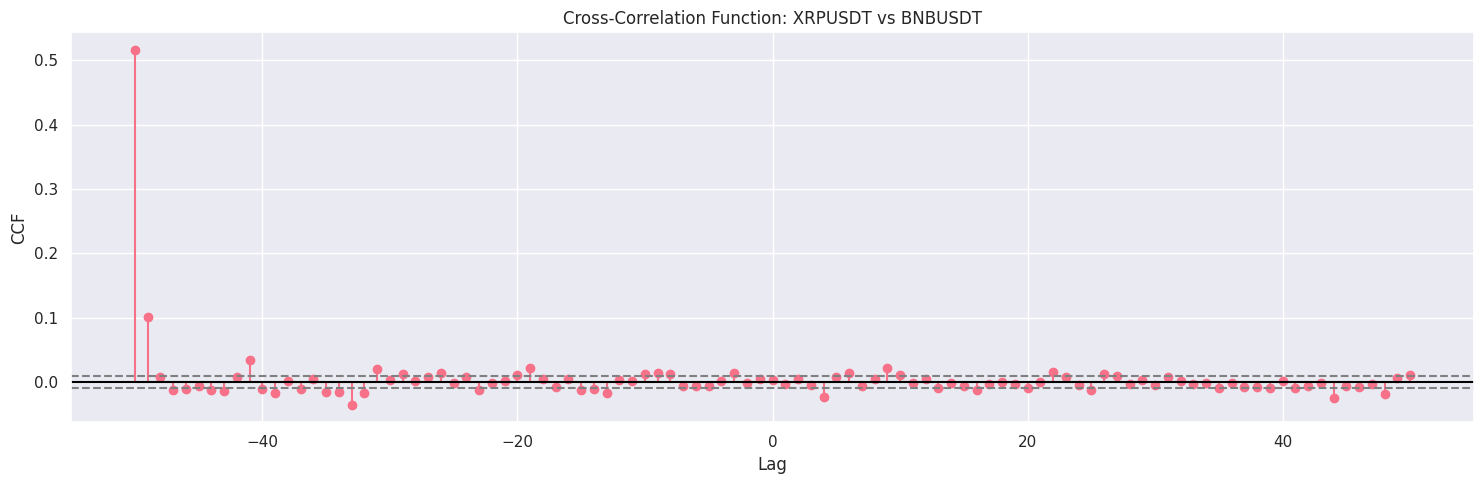

Significant lags between XRPUSDT and BNBUSDT:
BNBUSDT leads XRPUSDT by 50 periods (correlation: 0.516)
BNBUSDT leads XRPUSDT by 49 periods (correlation: 0.101)
BNBUSDT leads XRPUSDT by 47 periods (correlation: -0.011)
BNBUSDT leads XRPUSDT by 46 periods (correlation: -0.010)
BNBUSDT leads XRPUSDT by 44 periods (correlation: -0.012)
BNBUSDT leads XRPUSDT by 43 periods (correlation: -0.013)
BNBUSDT leads XRPUSDT by 41 periods (correlation: 0.034)
BNBUSDT leads XRPUSDT by 40 periods (correlation: -0.010)
BNBUSDT leads XRPUSDT by 39 periods (correlation: -0.017)
BNBUSDT leads XRPUSDT by 37 periods (correlation: -0.010)
BNBUSDT leads XRPUSDT by 35 periods (correlation: -0.014)
BNBUSDT leads XRPUSDT by 34 periods (correlation: -0.015)
BNBUSDT leads XRPUSDT by 33 periods (correlation: -0.034)
BNBUSDT leads XRPUSDT by 32 periods (correlation: -0.016)
BNBUSDT leads XRPUSDT by 31 periods (correlation: 0.021)
BNBUSDT leads XRPUSDT by 29 periods (correlation: 0.014)
BNBUSDT leads XRPUSDT by 26 per

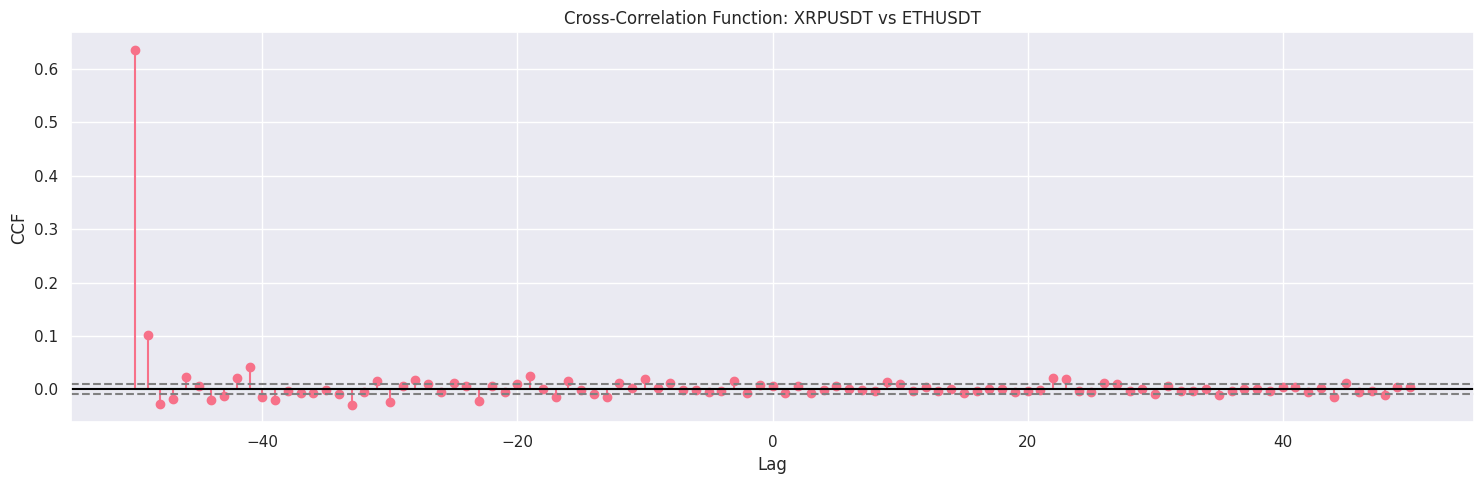

Significant lags between XRPUSDT and ETHUSDT:
ETHUSDT leads XRPUSDT by 50 periods (correlation: 0.635)
ETHUSDT leads XRPUSDT by 49 periods (correlation: 0.101)
ETHUSDT leads XRPUSDT by 48 periods (correlation: -0.027)
ETHUSDT leads XRPUSDT by 47 periods (correlation: -0.018)
ETHUSDT leads XRPUSDT by 46 periods (correlation: 0.023)
ETHUSDT leads XRPUSDT by 44 periods (correlation: -0.019)
ETHUSDT leads XRPUSDT by 43 periods (correlation: -0.013)
ETHUSDT leads XRPUSDT by 42 periods (correlation: 0.022)
ETHUSDT leads XRPUSDT by 41 periods (correlation: 0.042)
ETHUSDT leads XRPUSDT by 40 periods (correlation: -0.015)
ETHUSDT leads XRPUSDT by 39 periods (correlation: -0.020)
ETHUSDT leads XRPUSDT by 33 periods (correlation: -0.028)
ETHUSDT leads XRPUSDT by 31 periods (correlation: 0.016)
ETHUSDT leads XRPUSDT by 30 periods (correlation: -0.023)
ETHUSDT leads XRPUSDT by 28 periods (correlation: 0.017)
ETHUSDT leads XRPUSDT by 27 periods (correlation: 0.010)
ETHUSDT leads XRPUSDT by 25 period

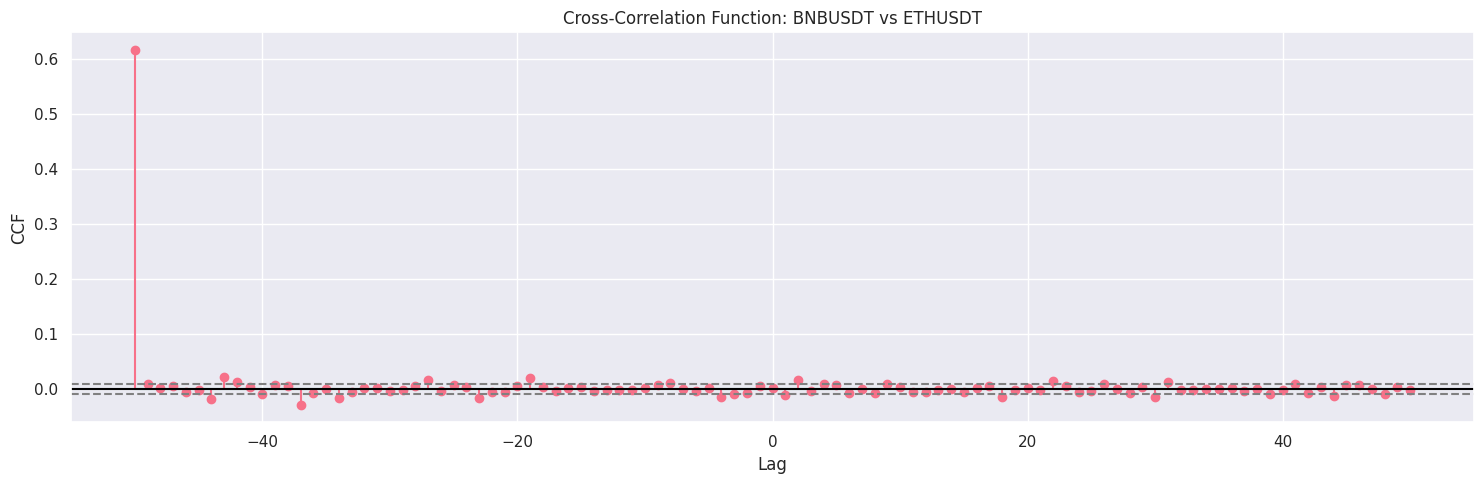

Significant lags between BNBUSDT and ETHUSDT:
ETHUSDT leads BNBUSDT by 50 periods (correlation: 0.615)
ETHUSDT leads BNBUSDT by 49 periods (correlation: 0.010)
ETHUSDT leads BNBUSDT by 44 periods (correlation: -0.018)
ETHUSDT leads BNBUSDT by 43 periods (correlation: 0.022)
ETHUSDT leads BNBUSDT by 42 periods (correlation: 0.013)
ETHUSDT leads BNBUSDT by 40 periods (correlation: -0.010)
ETHUSDT leads BNBUSDT by 37 periods (correlation: -0.028)
ETHUSDT leads BNBUSDT by 34 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 27 periods (correlation: 0.016)
ETHUSDT leads BNBUSDT by 23 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 19 periods (correlation: 0.020)
ETHUSDT leads BNBUSDT by 8 periods (correlation: 0.011)
ETHUSDT leads BNBUSDT by 4 periods (correlation: -0.014)
BNBUSDT leads ETHUSDT by 1 periods (correlation: -0.011)
BNBUSDT leads ETHUSDT by 2 periods (correlation: 0.016)
BNBUSDT leads ETHUSDT by 4 periods (correlation: 0.010)
BNBUSDT leads ETHUSDT by 9 periods (corr

In [26]:
# Get all unique pairs of cryptocurrencies
crypto_pairs = list(itertools.combinations(returns_data.keys(), 2))

# Plot CCF for each pair
for pair in crypto_pairs:
    symbol1, symbol2 = pair
    print(f"\nAnalyzing cross-correlation between {symbol1} and {symbol2}")
    plot_ccf(
        returns_data[symbol1]['returns'],
        returns_data[symbol2]['returns'],
        symbol1,
        symbol2
    )

## ACF Analysis with Confidence Intervals
Let's look at the autocorrelation structure of each cryptocurrency's returns,
including confidence intervals to identify significant correlations.

In [27]:
def plot_detailed_acf(series, symbol, lags=50):
    # Calculate ACF with confidence intervals
    acf_values, confint = acf(series.dropna(), nlags=lags, alpha=0.05, fft=False)

    plt.figure(figsize=(15, 5))
    plt.stem(range(len(acf_values)), acf_values)
    plt.axhline(y=0, linestyle='-', color='black')

    # Plot confidence intervals
    plt.fill_between(
        range(len(acf_values)),
        confint[:, 0],
        confint[:, 1],
        alpha=0.1,
        color='blue'
    )

    plt.title(f'Autocorrelation Function for {symbol}')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.tight_layout()
    plt.show()

    # Print significant lags
    significant_lags = np.where(
        (acf_values < confint[:, 0]) |
        (acf_values > confint[:, 1])
    )[0]
    if len(significant_lags) > 0:
        print(f"\nSignificant autocorrelations for {symbol}:")
        for lag in significant_lags:
            print(f"Lag {lag}: {acf_values[lag]:.3f}")


Analyzing autocorrelation for SOLUSDT


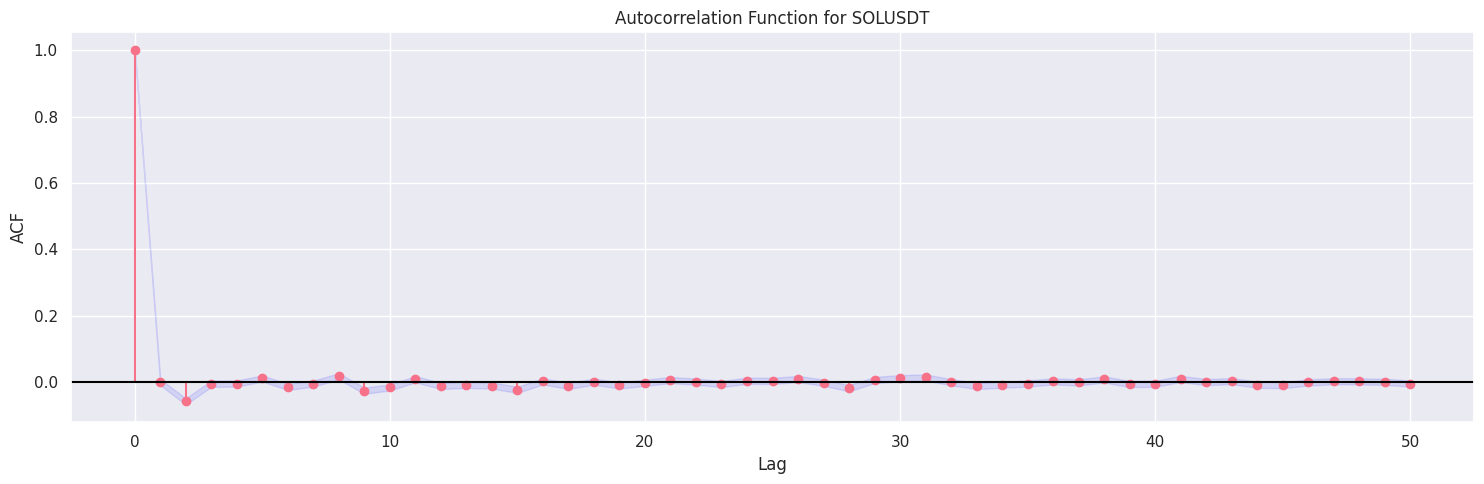


Analyzing autocorrelation for ADAUSDT


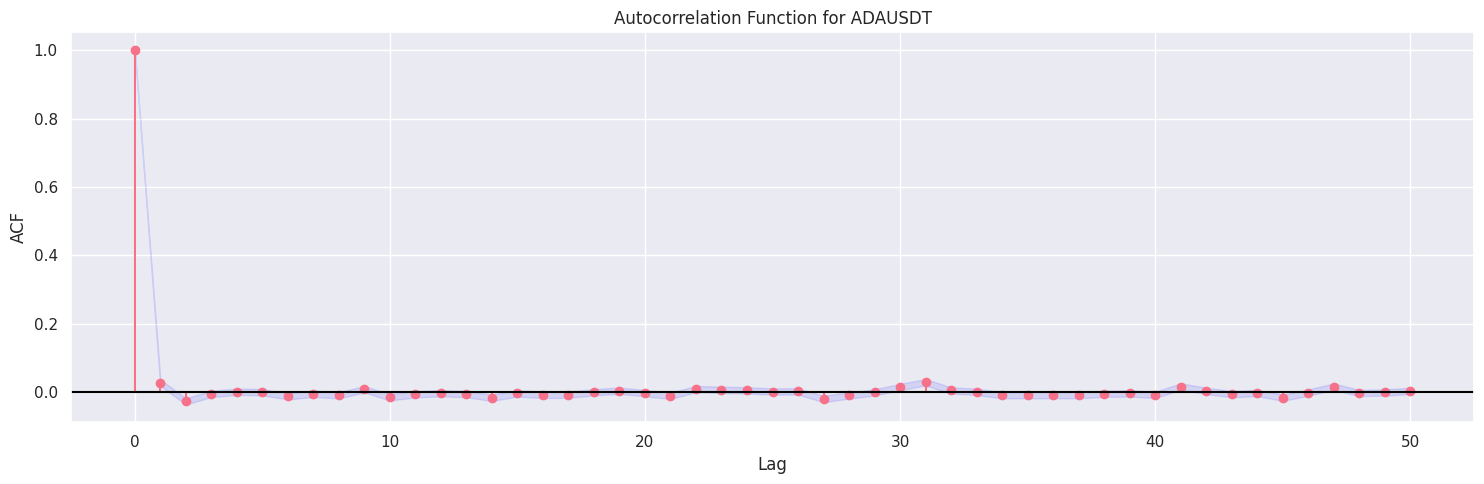


Analyzing autocorrelation for BTCUSDT


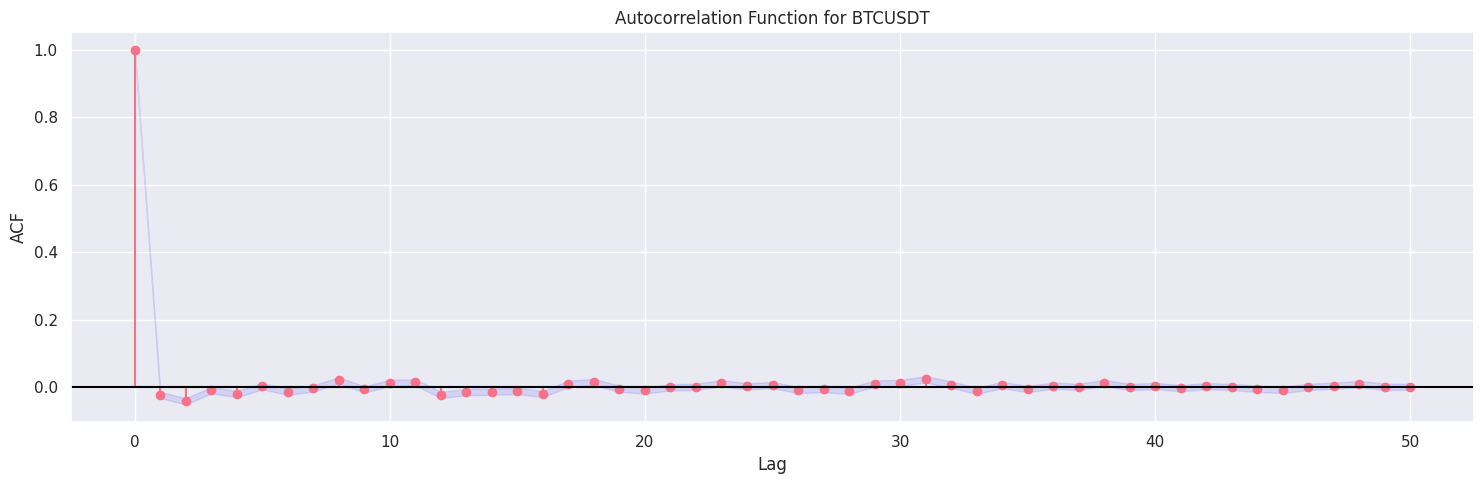


Analyzing autocorrelation for DOGEUSDT


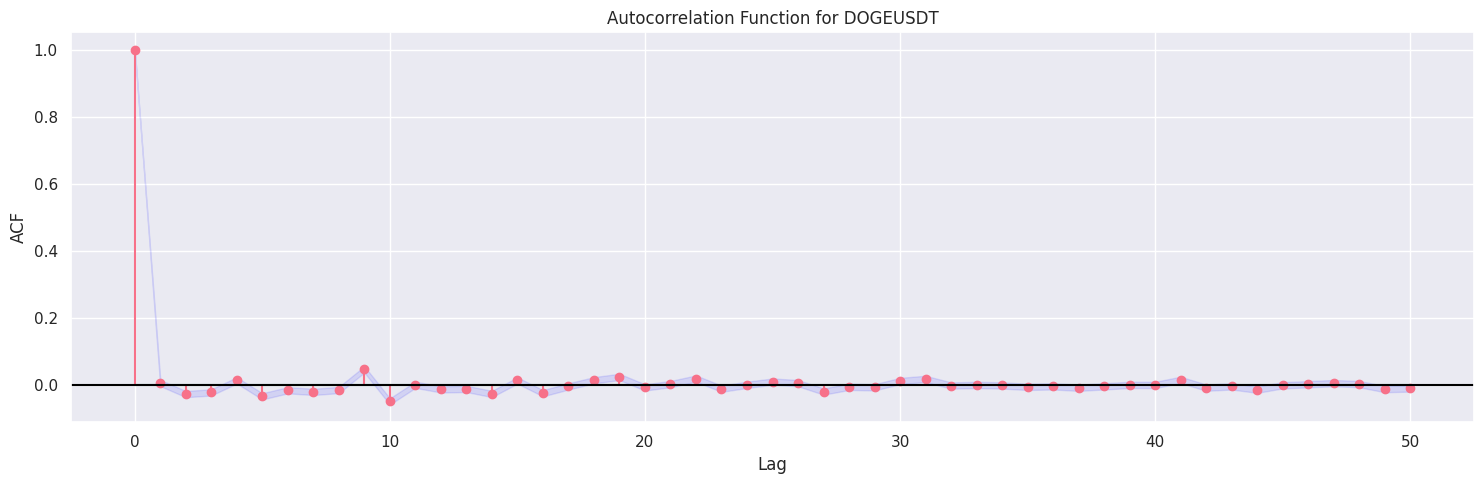


Analyzing autocorrelation for XRPUSDT


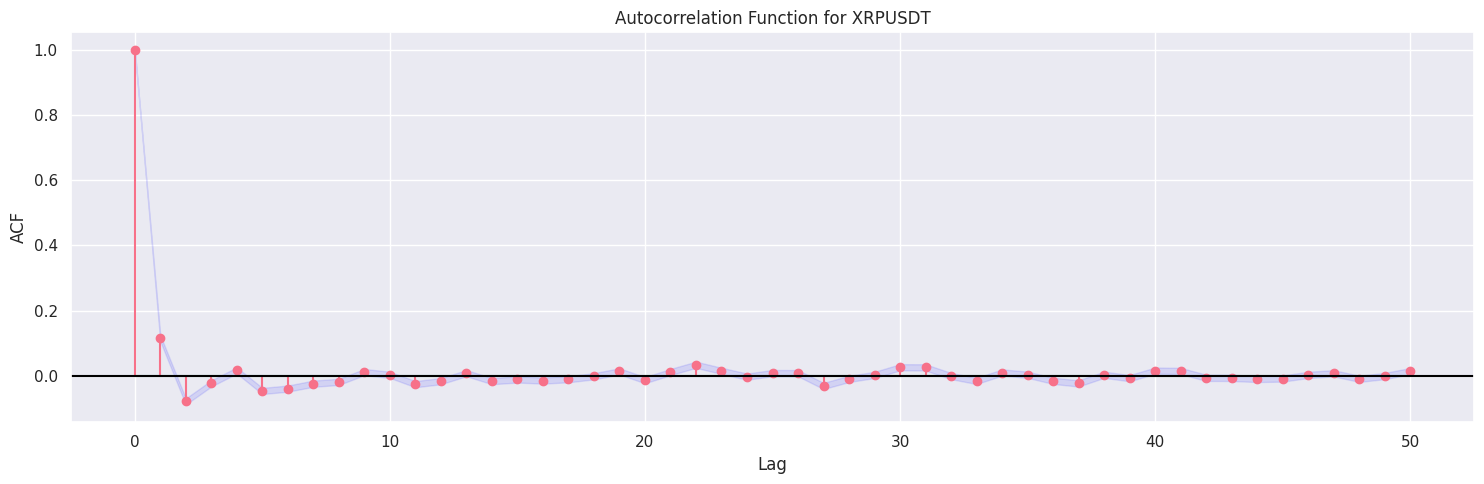


Analyzing autocorrelation for BNBUSDT


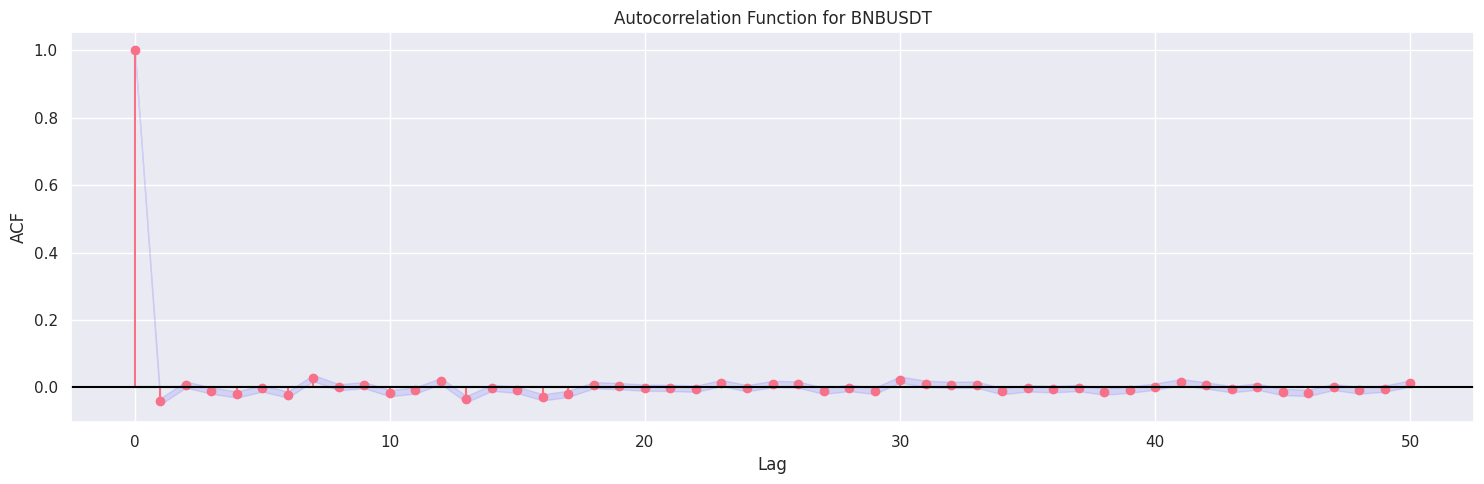


Analyzing autocorrelation for ETHUSDT


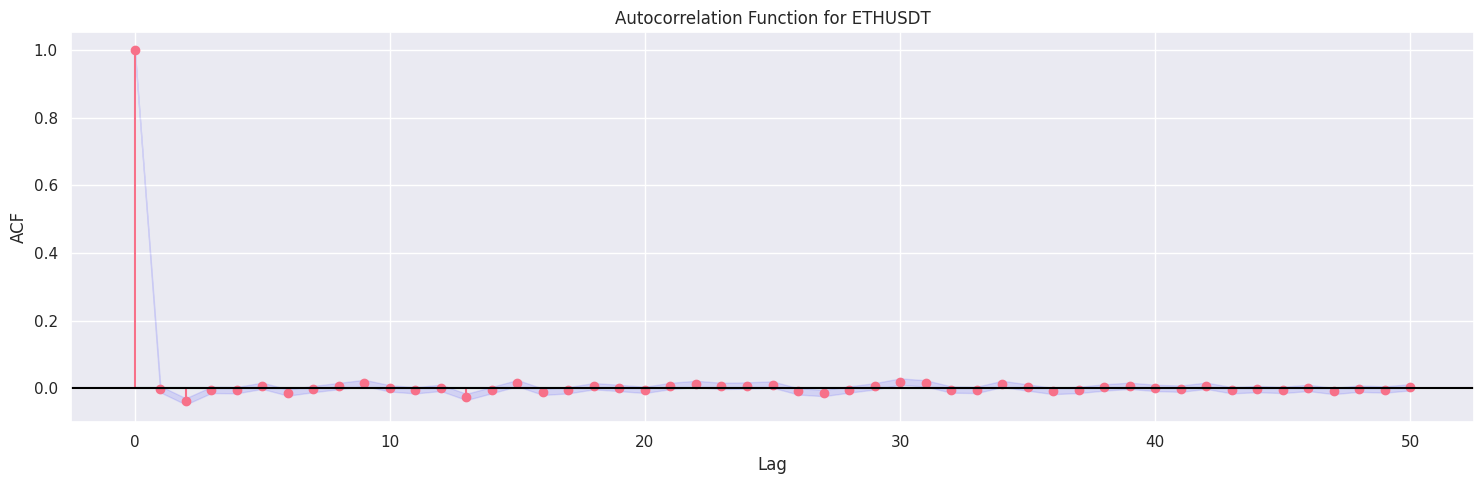

In [28]:
# Plot ACF for each cryptocurrency
for symbol, returns in returns_data.items():
    print(f"\nAnalyzing autocorrelation for {symbol}")
    plot_detailed_acf(returns['returns'], symbol)

## Summary of Lead-Lag Relationships
Let's create a summary table of the strongest lead-lag relationships found.

In [29]:
def create_lead_lag_summary(returns_data, lags=50):
    summary_data = []

    for pair in itertools.combinations(returns_data.keys(), 2):
        symbol1, symbol2 = pair
        ccf_values = ccf(
            returns_data[symbol1]['returns'].dropna(),
            returns_data[symbol2]['returns'].dropna(),
            adjusted=False
        )

        # Find max correlation and corresponding lag
        max_corr_idx = np.argmax(np.abs(ccf_values))
        max_corr = ccf_values[max_corr_idx]
        max_lag = max_corr_idx - lags

        if max_lag < 0:
            leader = symbol2
            lagger = symbol1
            lag = abs(max_lag)
        else:
            leader = symbol1
            lagger = symbol2
            lag = max_lag

        summary_data.append({
            'Leader': leader,
            'Lagger': lagger,
            'Lag (minutes)': lag,
            'Correlation': max_corr
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df.sort_values('Correlation', key=abs, ascending=False)

In [30]:
summary_df = create_lead_lag_summary(returns_data)
print("Summary of Strongest Lead-Lag Relationships:")
print(summary_df)

Summary of Strongest Lead-Lag Relationships:
      Leader    Lagger  Lag (minutes)  Correlation
14   ETHUSDT   BTCUSDT             50     0.796184
10   ETHUSDT   ADAUSDT             50     0.751736
1    BTCUSDT   SOLUSDT             50     0.726179
0    ADAUSDT   SOLUSDT             50     0.724899
6    BTCUSDT   ADAUSDT             50     0.716196
7   DOGEUSDT   ADAUSDT             50     0.695701
5    ETHUSDT   SOLUSDT             50     0.692153
8    XRPUSDT   ADAUSDT             50     0.684802
15   XRPUSDT  DOGEUSDT             50     0.662347
17   ETHUSDT  DOGEUSDT             50     0.654348
19   ETHUSDT   XRPUSDT             50     0.635185
9    BNBUSDT   ADAUSDT             50     0.618289
20   ETHUSDT   BNBUSDT             50     0.615470
11  DOGEUSDT   BTCUSDT             50     0.615023
2   DOGEUSDT   SOLUSDT             50     0.593955
12   XRPUSDT   BTCUSDT             50     0.592986
13   BNBUSDT   BTCUSDT             50     0.577927
3    XRPUSDT   SOLUSDT             50

## Summary Statistics and Volatility Analysis

In [31]:
# Summary Statistics
summary_stats = pd.DataFrame()
for symbol, returns in returns_data.items():
    stats = returns['returns'].describe()
    stats['skewness'] = returns['returns'].skew()
    stats['kurtosis'] = returns['returns'].kurtosis()
    summary_stats[symbol] = stats

print("\nSummary Statistics for Returns:")
print(summary_stats)


Summary Statistics for Returns:
               SOLUSDT       ADAUSDT       BTCUSDT      DOGEUSDT  \
count     4.464000e+04  44640.000000  4.464000e+04  44640.000000   
mean     -9.813730e-07     -0.000004  1.763238e-07     -0.000003   
std       1.685472e-03      0.001276  8.059727e-04      0.001179   
min      -7.400775e-02     -0.049435 -2.735821e-02     -0.054418   
25%      -8.237081e-04     -0.000602 -3.163289e-04     -0.000482   
50%       0.000000e+00      0.000000  0.000000e+00      0.000000   
75%       8.222598e-04      0.000593  3.231704e-04      0.000478   
max       4.949699e-02      0.025432  1.501286e-02      0.054653   
skewness -3.040017e+00     -3.229180 -3.173194e+00     -2.799927   
kurtosis  1.661567e+02    132.429948  1.238676e+02    383.833120   

               XRPUSDT       BNBUSDT       ETHUSDT  
count     44640.000000  4.464000e+04  4.464000e+04  
mean         -0.000004 -8.261214e-07  4.246179e-08  
std           0.001082  9.118501e-04  8.247499e-04  
min   

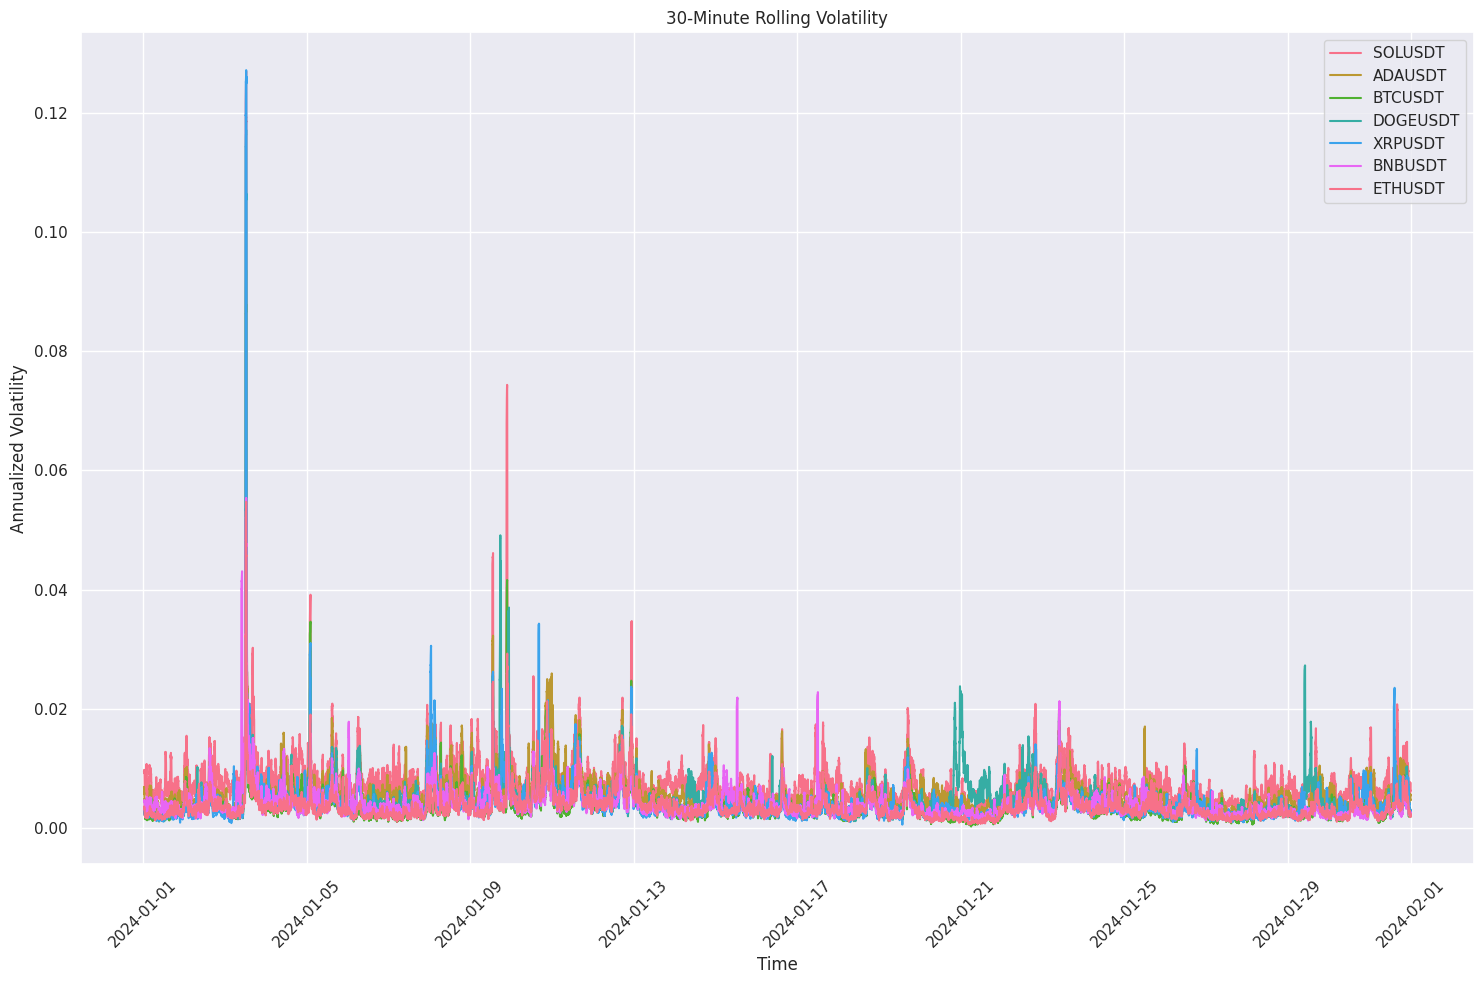

In [32]:
# Volatility Analysis
# Calculate rolling volatility (30-minute window)
plt.figure(figsize=(15, 10))
for symbol, returns in returns_data.items():
    vol = returns['returns'].rolling(window=30).std() * np.sqrt(30)
    plt.plot(returns['timestamp'], vol, label=symbol)

plt.title('30-Minute Rolling Volatility')
plt.xlabel('Time')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()